In [1]:
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import pandas as pd
import glob
import h5py
import re
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve
from tqdm import tqdm
import scipy.io as sio
from joblib import Parallel, delayed
import os
import pickle
import argparse
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import tqdm
import itertools

plt.rcParams.update({'font.size': 20})

In [2]:
'''load regression info'''

root_dir = '/dartfs-hpc/scratch/f005d7d/what_where_analysis/'
figure_data_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/what_where_analysis/what-where-task-analysis/figures'
processed_path = os.path.join(root_dir, 'processed/')

with open(os.path.join(processed_path, 'all_sess_regression_info.pkl'), 'rb') as f:
    all_sess_regression_info = pickle.load(f)

In [3]:
'''load original neural data'''

monkey_names = ["W", "V"]
# aligned_events = ["StimOnset", "Choice", "RewFeedback"]
aligned_events = ["StimOnset"]

neural_path = os.path.join(root_dir, 'RasterVec_binSize_10ms/')
bhv_path = os.path.join(root_dir, 'Behavior/')

binsize = 0.01
# gauss_SD = 0.02/binsize
win_size = int(0.05/binsize)
stride = int(0.05/binsize)

all_sess_neural_data = []
all_sess_task_info = []

for event_idx, aligned_event in enumerate(aligned_events):
    for monkey_idx, monkey_name in enumerate(monkey_names):
        files = glob.glob(
            f'{neural_path}/{aligned_event}/RastVect-{monkey_name}*-binsize10ms-align2{aligned_event}.mat')
        for sess_idx in range(len(files)):
            filename = files[sess_idx]

            curr_sess_neural = h5py.File(filename)
            sess_date = re.search(re.compile(
                f'RastVect-{monkey_name}(\\d*)-binsize10ms-align2{aligned_event}.mat'), filename).groups()[0]

#             neural_data = gaussian_filter(curr_sess_neural['aligned2event'], gauss_SD, mode='constant', axes=2)
            neural_data = convolve(curr_sess_neural['aligned2event'], np.ones((1,1,win_size))/win_size, mode='valid')[:,:,::stride]
            
            bhv_filename = bhv_path+'SPKcounts_'+monkey_name+sess_date+'cue_MW_250X250ms.mat'
            curr_sess_bhv = sio.loadmat(
                bhv_path+'SPKcounts_'+monkey_name+sess_date+'cue_MW_250X250ms.mat')
            task_info = curr_sess_bhv['Y']

            # only keep chosen image, chosen loc, reward, block type, 
            # block id (by type), correct choice, block id (by order)
            task_info = task_info[:, [0, 1, 2, 9, 7, 5, 4, 8]].astype(float)

            trial_mask = task_info[:, 4] <= 24
            task_info = task_info[trial_mask]
            
            all_sess_task_info.append(task_info)
            neural_data = neural_data[trial_mask]

            neuron_mask = np.nonzero(np.min(neural_data.sum(0), 1))[0]
            neural_data = neural_data[:, neuron_mask, :]            
            
            all_sess_neural_data.append(neural_data)
            
            print("aligned to: " + aligned_event + ", monkey: " + monkey_name + ", session: " + sess_date)
            
num_timesteps = neural_data.shape[-1]
            

aligned to: StimOnset, monkey: W, session: 20160122
aligned to: StimOnset, monkey: W, session: 20160112
aligned to: StimOnset, monkey: W, session: 20160121
aligned to: StimOnset, monkey: W, session: 20160113
aligned to: StimOnset, monkey: V, session: 20160929
aligned to: StimOnset, monkey: V, session: 20160930
aligned to: StimOnset, monkey: V, session: 20161005
aligned to: StimOnset, monkey: V, session: 20161017


In [4]:
def plot_mean_se(ax, xxx, yyy, color, label, axis):
    mean = yyy.mean(axis)
    se = yyy.std(axis)/np.sqrt(yyy.shape[axis])
    ax.plot(xxx, mean, c=color, label=label, lw=2)
    ax.fill_between(xxx, mean-se, mean+se, color=color, alpha=0.2)
    

In [5]:
all_sess_exp_var = np.concatenate(all_sess_regression_info['pvals'], axis=1)<0.05
all_sess_betas = np.concatenate(all_sess_regression_info['betas'], axis=1)

num_timesteps = neural_data.shape[-1]
xxx = np.linspace(-1500, 1500-stride*binsize*1000, num=num_timesteps)

In [6]:
def plot_time_varying_correlation(xxx, yyy, ax, title, vlim=0.4, metric='corr'):        
    
    if metric=='cosine':
        sim = (xxx/np.linalg.norm(xxx, axis=-1, keepdims=True))@\
                    (yyy/np.linalg.norm(yyy, axis=-1, keepdims=True)).T
    if metric=='dot':
        sim = (xxx)@(yyy).T
    elif metric=='corr':
        sim = np.corrcoef(xxx, yyy)[:num_timesteps,num_timesteps:]
    elif metric=='cov':
        sim = np.cov(xxx, yyy)[:num_timesteps,num_timesteps:]
    elif metric=='spearman':
        sim = stats.spearmanr(xxx.T, yyy.T).statistic[:num_timesteps,num_timesteps:]
    
    
    if vlim is None:
        vlim = np.abs(sim).max()
    
    sns.heatmap(sim, 
                cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
                ax=ax, square=True, cbar_kws={'shrink': 0.7})
    ax.axvline(50, ls=':', c='grey')
    ax.axhline(50, ls=':', c='grey')
    ax.axvline(30, ls=':', c='grey')
    ax.axhline(30, ls=':', c='grey')
    ax.axvline(18, ls=':', c='grey')
    ax.axhline(18, ls=':', c='grey')
    ax.set_title(title)
    ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=0)
    ax.set_yticks([], [])
    
    return sim


    

In [7]:
def trialwise_subspace_alignment(neural_data, task_info, betas, betas_func, axes, absolute_proj=False):
    # neural_data should be num_trials X num_neurons X num_timesteps
    # trial_indices should be num_trials
    # block_types should be num_trials
    # subspace should be num_neurons X num_timesteps
    
    num_sess = len(neural_data)
        
    num_trials, num_neurons, num_timesteps = neural_data[0].shape
    
    num_trials_per_block = np.max(task_info[0][:,5]).astype(int)

    all_sess_avg_alignment = np.empty((2, num_trials_per_block, num_timesteps))*np.nan
    
    all_sess_alignment = []
    all_sess_block_trial = []
    
    
    for idx_sess in tqdm.tqdm(range(num_sess)):
        subspace = betas_func(betas[idx_sess])
        
        normed_subspace = subspace/(np.linalg.norm(subspace, axis=1, keepdims=True)+1e-8)
        
        centered_neural_data = neural_data[idx_sess]-neural_data[idx_sess].mean(0)
        
        curr_sess_alignment = (centered_neural_data*normed_subspace.T[None]).sum(-2)
        
        if absolute_proj:
            curr_sess_alignment = (curr_sess_alignment)**2
            
        
        all_sess_alignment.append(curr_sess_alignment)
        all_sess_block_trial.append(task_info[idx_sess][:,[3,5]])
        
    all_sess_alignment = np.concatenate(all_sess_alignment, 0)
    all_sess_block_trial = np.concatenate(all_sess_block_trial, 0)
    
    
    for idx_block in range(2):
        for idx_trial in range(num_trials_per_block):
            curr_trial_mask = (all_sess_block_trial[:,0]==idx_block+1) & (all_sess_block_trial[:,1]==idx_trial+1)
            all_sess_avg_alignment[idx_block, idx_trial] = \
                np.sum(all_sess_alignment[curr_trial_mask], axis=0)/curr_trial_mask.sum()
    
    vlims = np.max(np.abs(all_sess_avg_alignment[0]))
    sns.heatmap(all_sess_avg_alignment[0], ax=axes[0], vmin=-vlims, vmax=vlims, cmap='RdBu_r')
    axes[0].set_ylabel('What block')
    
    vlims = np.max(np.abs(all_sess_avg_alignment[1]))
    sns.heatmap(all_sess_avg_alignment[1], ax=axes[1], vmin=-vlims, vmax=vlims, cmap='RdBu_r')
    axes[1].set_ylabel('Where block')
    
    vlims = np.max(np.abs(all_sess_avg_alignment[0]-all_sess_avg_alignment[1]))
    sns.heatmap(all_sess_avg_alignment[0]-all_sess_avg_alignment[1], ax=axes[2], 
                vmin=-vlims, vmax=vlims, cmap='RdBu_r')
    axes[2].set_ylabel('What-where')
    
    for ax in axes:
        ax.set_yticks(np.arange(10, 80, 20))
        ax.set_yticklabels(np.arange(10, 80, 20))
        ax.axvline(50, ls=':', c='k', lw=1)
        ax.axvline(30, ls=':', c='k', lw=1)
        ax.axvline(18, ls=':', c='k', lw=1)
        ax.axhline(30, ls=':', c='grey', lw=1)
        ax.axhline(50, ls=':', c='grey', lw=1)
        ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=0)
    
    return all_sess_avg_alignment
        

In [8]:
def alignment_perf_corr(neural_data, task_info, betas, betas_func, axes):
    # neural_data should be num_trials X num_neurons X num_timesteps
    # trial_indices should be num_trials
    # block_types should be num_trials
    # subspace should be num_neurons X num_timesteps
    
    num_sess = len(neural_data)
    
    num_trials, num_neurons, num_timesteps = neural_data[0].shape
    num_timesteps -= 20
    
    num_blocks = 24
    
    all_sess_alignment = []
    all_sess_block_perf = []
    
    for idx_sess in tqdm.tqdm(range(num_sess)):
        subspace = betas_func(betas[idx_sess])
        
        normed_subspace = subspace/(np.linalg.norm(subspace, axis=1, keepdims=True)+1e-8)
        
        curr_sess_alignment = (neural_data[idx_sess]*normed_subspace.T[None]).sum(-2).mean(1) # num_trials
        
        for idx_block in range(num_blocks):
            curr_trial_mask = task_info[idx_sess][:,7]==idx_block+1
            block_type = np.median(task_info[idx_sess][curr_trial_mask,3])
            all_sess_alignment.append(
                (block_type*2-3)*np.sum(curr_sess_alignment[curr_trial_mask], axis=0)/curr_trial_mask.sum())
            all_sess_block_perf.append(np.sum(task_info[idx_sess][curr_trial_mask,2], axis=0)/curr_trial_mask.sum())
        
    
    all_sess_alignment = np.array(all_sess_alignment)
    all_sess_block_perf = np.array(all_sess_block_perf)


    sns.regplot(x=all_sess_alignment, y=all_sess_block_perf)
    
    print(stats.pearsonr(all_sess_alignment, all_sess_block_perf))
    
    return 


## Presence of task-relevant information in the population

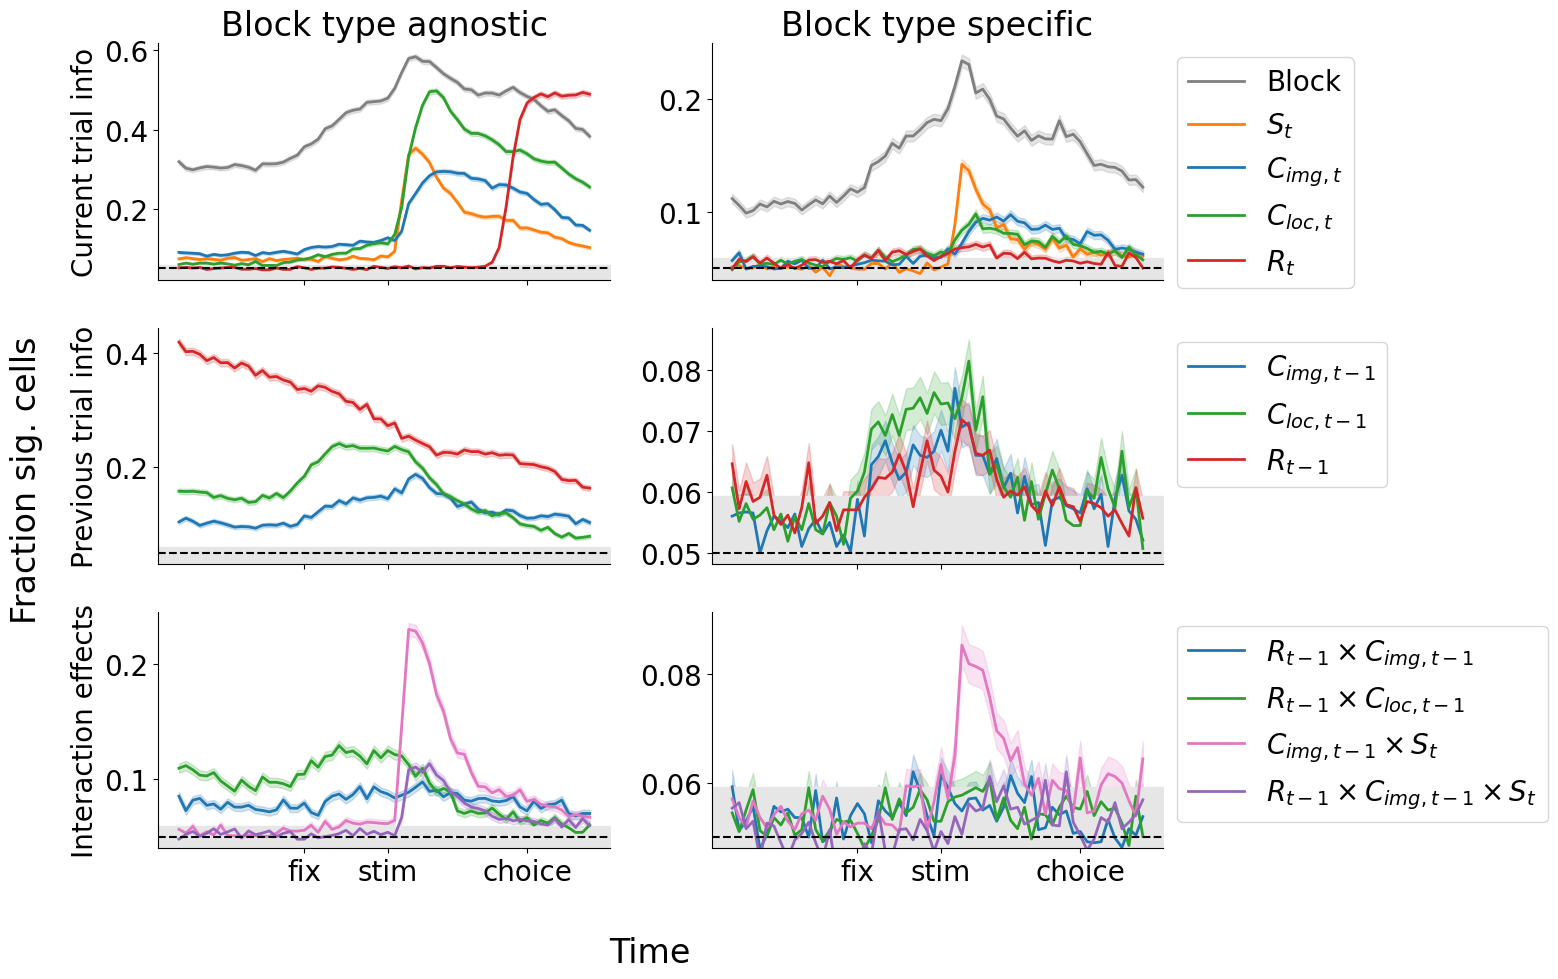

In [9]:
fig, axes = plt.subplots(3,2, sharex=True, figsize=(16, 10))

'''Current trial info'''

colors = ['tab:grey', 'tab:orange', 'tab:blue', 'tab:green', 'tab:red']

plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,2], color=colors[0], label='Block', axis=1)
plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,5], color=colors[1], label=r'$S_{t}$', axis=1)
plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,8], color=colors[2], label=r'$C_{img, t}$', axis=1)
plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,9], color=colors[3], label=r'$C_{loc, t}$', axis=1)
plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,11], color=colors[4], label=r'$R_{t}$', axis=1)


plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,1], color=colors[0], label='Block', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,4], color=colors[1], label=r'$S_{t}$', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,7], color=colors[2], label=r'$C_{img, t}$', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,10], color=colors[3], label=r'$C_{loc, t}$', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,13], color=colors[4], label=r'$R_{t}$', axis=1)

axes[0,0].set_title('Block type agnostic')
axes[0,1].set_title('Block type specific')
axes[0,0].set_ylabel('Current trial info')

# axes[0].ticklabel_format(style='sci', scilimits=(0,6), useMathText=True)
# axes[1].ticklabel_format(style='sci', scilimits=(0,6), useMathText=True)


axes[0,1].legend(bbox_to_anchor=(1., 1.))


'''Prev trial info'''

colors=['tab:blue', 'tab:green', 'tab:red']

plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,15], color=colors[0], label=r'$C_{img, t-1}$', axis=1)
plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,16], color=colors[1], label=r'$C_{loc, t-1}$', axis=1)
plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,18], color=colors[2], label=r'$R_{t-1}$', axis=1)


plot_mean_se(axes[1,1], xxx, all_sess_exp_var[...,14], color=colors[0], label=r'$C_{img, t-1}$', axis=1)
plot_mean_se(axes[1,1], xxx, all_sess_exp_var[...,17], color=colors[1], label=r'$C_{loc, t-1}$', axis=1)
plot_mean_se(axes[1,1], xxx, all_sess_exp_var[...,19], color=colors[2], label=r'$R_{t-1}$', axis=1)


axes[1,0].set_ylabel('Previous trial info')
axes[1,1].legend(bbox_to_anchor=(1., 1.))


'''Interaction effects'''

colors= ['tab:orange', 'tab:blue', 'tab:green', 'tab:pink', 'tab:purple']

# plot_mean_se(axes[2,0], xxx, all_sess_exp_var[...,29], color=colors[0], label=r'$R_{t-1}\times S_{t}$', axis=1)
plot_mean_se(axes[2,0], xxx, all_sess_exp_var[...,24], color=colors[1], 
             label=r'$R_{t-1}\times C_{img, t-1}$', axis=1)
plot_mean_se(axes[2,0], xxx, all_sess_exp_var[...,20], color=colors[2], 
             label=r'$R_{t-1}\times C_{loc, t-1}$', axis=1)
plot_mean_se(axes[2,0], xxx, all_sess_exp_var[...,25], color=colors[3], 
             label=r'$C_{img, t-1} \times S_{t}$', axis=1)
plot_mean_se(axes[2,0], xxx, all_sess_exp_var[...,30], color=colors[4], 
             label=r'$R_{t-1}\times C_{img, t-1} \times S_{t}$', axis=1)

# plot_mean_se(axes[2,1], xxx, all_sess_exp_var[...,28], color=colors[0], label=None, axis=1)
plot_mean_se(axes[2,1], xxx, all_sess_exp_var[...,23], color=colors[1], 
             label=r'$R_{t-1}\times C_{img, t-1}$', axis=1)
plot_mean_se(axes[2,1], xxx, all_sess_exp_var[...,21], color=colors[2], 
             label=r'$R_{t-1}\times C_{loc, t-1}$', axis=1)
plot_mean_se(axes[2,1], xxx, all_sess_exp_var[...,26], color=colors[3], 
             label=r'$C_{img, t-1} \times S_{t}$', axis=1)
plot_mean_se(axes[2,1], xxx, all_sess_exp_var[...,31], color=colors[4], 
             label=r'$R_{t-1}\times C_{img, t-1} \times S_{t}$', axis=1)

thresh = stats.binom.ppf(1-0.05/all_sess_exp_var.shape[0], all_sess_exp_var.shape[1], 0.05)\
                    /all_sess_exp_var.shape[1]

for a_row in axes:
    for a in a_row:
        a.axhline(0.05, ls='--', c='k')
        a.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'])
        ylims = [0.05-(a.get_ylim()[1]-0.05)*0.05, a.get_ylim()[1]]
        a.set_ylim(ylims)
#         a.axhline(thresh, ls=':', c='k')
        xlims = a.get_xlim()
        a.fill_between(xlims, [0.0, 0.0], [thresh, thresh], color=[0.9, 0.9, 0.9])
        a.set_xlim(xlims)
        


axes[2,0].set_ylabel('Interaction effects')
axes[2,1].legend(bbox_to_anchor=(1., 1.))

fig.supylabel('Fraction sig. cells')
fig.supxlabel('Time', x=0.42, y=0.01)



sns.despine()

fig.tight_layout()

## Congruent coding of choice history

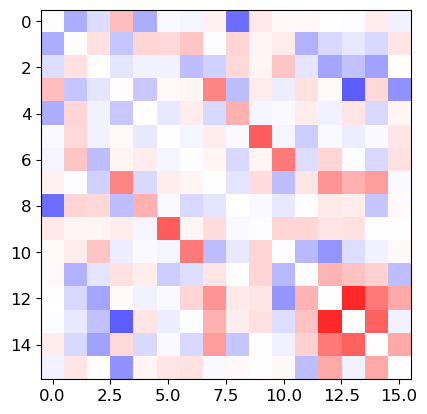

In [11]:
plt.imshow(np.corrcoef(all_sess_betas[:].mean(0)[:,[0,1,72,73,
                                                    74,75,
                                                    100,101,
                                                    102,103,
                                                    104,105,
                                                    130,131,
                                                    156,157]].T)-np.eye(16), 
           cmap='seismic', vmin=-0.8, vmax=0.8)


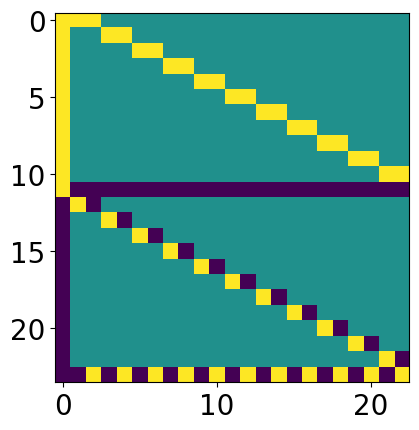

In [9]:
num_blocks_per_type = 12

block_contrasts = np.concatenate([np.ones(12), -np.ones(12)])
img_contrasts = np.concatenate([
    np.eye(num_blocks_per_type-1), -np.ones((1, num_blocks_per_type-1))
])

all_contrasts = np.ones((24,23))*np.nan

all_contrasts[:,0] = block_contrasts
all_contrasts[:num_blocks_per_type,1::2] = img_contrasts
all_contrasts[num_blocks_per_type:,1::2] = img_contrasts
all_contrasts[:num_blocks_per_type,2::2] = img_contrasts
all_contrasts[num_blocks_per_type:,2::2] = -img_contrasts

plt.imshow(all_contrasts)

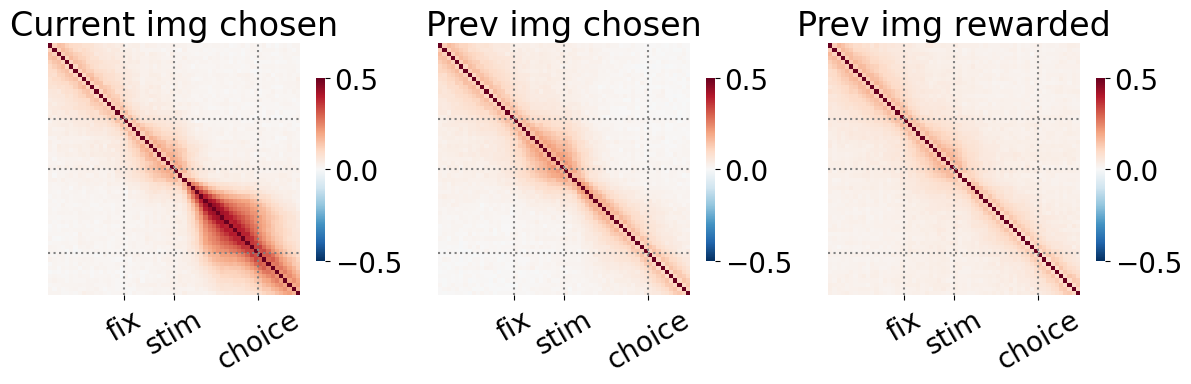

In [12]:
fig, axes = plt.subplots(1,3, figsize=(12, 4))

all_sims_img_curr = []
all_sims_img_cr = []
all_sims_img_wsls = []



for iii in range(24):
    
    curr_contrast = all_contrasts[iii,:][None,None]
    
    all_sims_img_curr.append(np.corrcoef(np.sum(all_sess_betas[...,48:71]*curr_contrast, -1), 
                                         np.sum(all_sess_betas[...,48:71]*curr_contrast, -1))[:num_timesteps,num_timesteps:])
    all_sims_img_cr.append(np.corrcoef(np.sum(all_sess_betas[...,76:99]*curr_contrast, -1), 
                                         np.sum(all_sess_betas[...,76:99]*curr_contrast, -1))[:num_timesteps,num_timesteps:])
    all_sims_img_wsls.append(np.corrcoef(np.sum(all_sess_betas[...,106:129]*curr_contrast, -1), 
                                         np.sum(all_sess_betas[...,106:129]*curr_contrast, -1))[:num_timesteps,num_timesteps:])

vlim=0.5
sns.heatmap(np.stack(all_sims_img_curr).mean(0), cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
            ax=axes[0], square=True, cbar_kws={'shrink': 0.6})
axes[0].set_title('Current img chosen')

vlim=0.5
sns.heatmap(np.stack(all_sims_img_cr).mean(0), cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
            ax=axes[1], square=True, cbar_kws={'shrink': 0.6})
axes[1].set_title('Prev img chosen')

vlim=0.5
sns.heatmap(np.stack(all_sims_img_wsls).mean(0), cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
            ax=axes[2], square=True, cbar_kws={'shrink': 0.6})
axes[2].set_title('Prev img rewarded')

for ax in axes:
    ax.axvline(50, ls=':', c='grey')
    ax.axhline(50, ls=':', c='grey')
    ax.axvline(30, ls=':', c='grey')
    ax.axhline(30, ls=':', c='grey')
    ax.axvline(18, ls=':', c='grey')
    ax.axhline(18, ls=':', c='grey')
    ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=30)
    ax.set_yticks([], [])

fig.tight_layout()


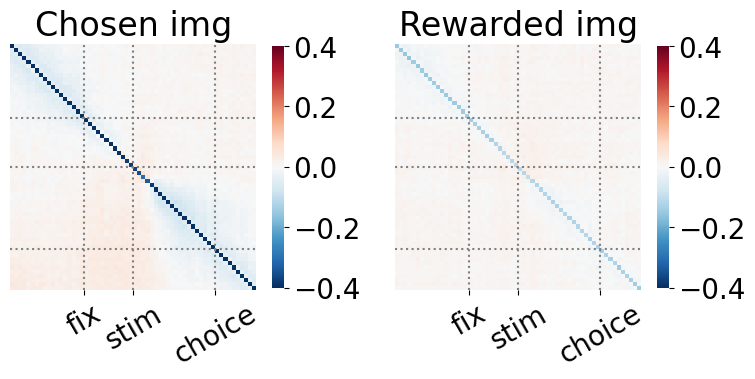

In [13]:
fig, axes = plt.subplots(1,2, figsize=(8, 4))

all_sims_img_cr = []
all_sims_img_wsls = []

for idx_sess in range(len(all_sess_regression_info['betas'])):
    curr_sess_betas = all_sess_regression_info['betas'][idx_sess]
    for iii in range(24):
        curr_contrast = all_contrasts[iii,:][None,None]
        all_sims_img_cr.append(np.corrcoef(
                np.sum(curr_sess_betas[...,48:71]*curr_contrast, -1), 
                np.sum(curr_sess_betas[...,76:99]*curr_contrast, -1))[:num_timesteps,num_timesteps:])
        all_sims_img_wsls.append(np.corrcoef(
                np.sum(curr_sess_betas[...,48:71]*curr_contrast, -1), 
                np.sum(curr_sess_betas[...,106:129]*curr_contrast, -1))[:num_timesteps,num_timesteps:])

vlim=0.4
sns.heatmap(np.stack(all_sims_img_cr).mean(0), cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
            ax=axes[0], square=True, cbar_kws={'shrink': 0.8})
axes[0].set_title('Chosen img')

vlim=0.4
sns.heatmap(np.stack(all_sims_img_wsls).mean(0), cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
            ax=axes[1], square=True, cbar_kws={'shrink': 0.8})
axes[1].set_title('Rewarded img')

for ax in axes:
    ax.axvline(50, ls=':', c='grey')
    ax.axhline(50, ls=':', c='grey')
    ax.axvline(30, ls=':', c='grey')
    ax.axhline(30, ls=':', c='grey')
    ax.axvline(18, ls=':', c='grey')
    ax.axhline(18, ls=':', c='grey')
    ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=30)
    ax.set_yticks([], [])

fig.tight_layout()


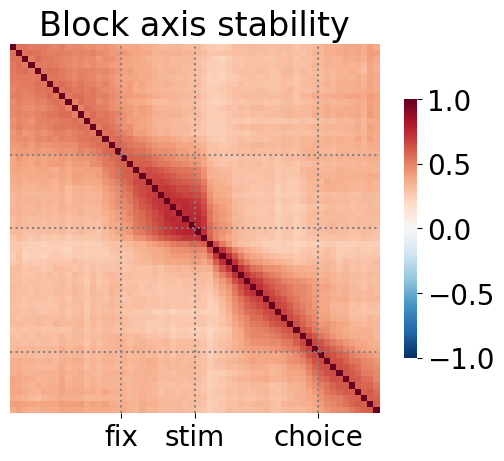

In [14]:
fig, axes = plt.subplots(1,1)

plot_time_varying_correlation(all_sess_betas[...,1],all_sess_betas[...,1], 
                              axes, title='Block axis stability', vlim=1);

In [15]:
def p_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def plot_pair_regressions(ax, x1, y1, x2, y2, axis_lims, xlabel, labels=[None, None]):
    
    xlims = max([np.max(np.abs(x1)), np.max(np.abs(x2))])*1.1
    ax.set_xlim([-xlims, xlims])
    ylims = max([np.max(np.abs(y1)), np.max(np.abs(y2))])*1.1
    ax.set_ylim([-ylims, ylims])

    sns.regplot(x=x1, y=y1, truncate=False, color='tab:red', scatter=False, label=labels[0], ax=ax)
    sns.regplot(x=x2, y=y2, truncate=False, color='tab:blue', scatter=False, label=labels[1], ax=ax)
    
    sns.scatterplot(x=x1, y=y1, color='tab:red', ax=ax, alpha=0.2, legend=False)
    sns.scatterplot(x=x2, y=y2, color='tab:blue', ax=ax, alpha=0.2, legend=False)
    
    r1 = stats.pearsonr(x1, y1)
    r2 = stats.pearsonr(x2, y2)
    
    zdr = (np.arctanh(r1.statistic)-np.arctanh(r2.statistic))\
                /np.sqrt(1/(x1.shape[0]-3)+1/(x2.shape[0]-3))
    
    ax.text(xlims*0.5, -ylims*0.5, f"R={np.round(r1.statistic, 2)} {p_to_asterisks(r1.pvalue)}", color='tab:red', fontsize=16)
    ax.text(xlims*0.5, -ylims*0.7, f"R={np.round(r2.statistic, 2)} {p_to_asterisks(r2.pvalue)}", color='tab:blue', fontsize=16)
    ax.text(xlims*0.5, -ylims*0.9, 
            f"$\\Delta R$={np.round(r1.statistic-r2.statistic, 2)} {p_to_asterisks(1-norm.cdf(np.abs(zdr)))}", 
            color='tab:purple', fontsize=16)
    
    ax.set_xlabel(xlabel)
    
    
    
    

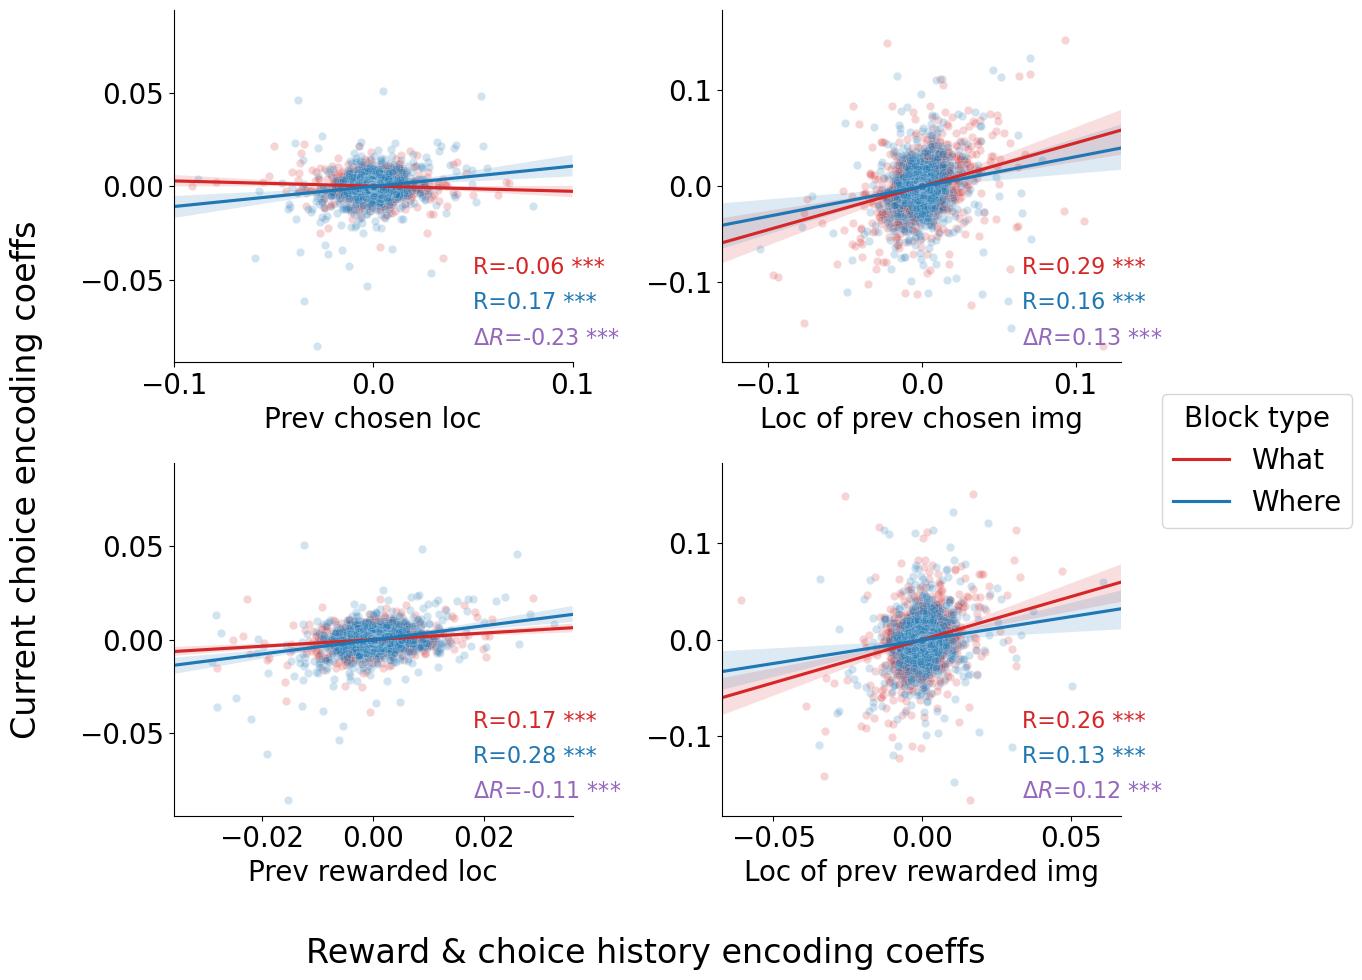

In [16]:
fig, axes = plt.subplots(2,2, figsize=(12,10))

plot_pair_regressions(axes[0,0], axis_lims=[-0.1, 0.1], xlabel='Prev chosen loc',
                      y1=(all_sess_betas[...,72]+all_sess_betas[...,73])[20:30].mean(0),
                      x1=(all_sess_betas[...,100]+all_sess_betas[...,101])[20:30].mean(0),
                      y2=(all_sess_betas[...,72]-all_sess_betas[...,73])[20:30].mean(0),
                      x2=(all_sess_betas[...,100]-all_sess_betas[...,101])[20:30].mean(0))

plot_pair_regressions(axes[1,0], axis_lims=[-0.1, 0.1], xlabel='Prev rewarded loc',
                      y1=(all_sess_betas[...,72]+all_sess_betas[...,73])[20:30].mean(0), 
                      x1=(all_sess_betas[...,104]+all_sess_betas[...,105])[20:30].mean(0),
                      y2=(all_sess_betas[...,72]-all_sess_betas[...,73])[20:30].mean(0),
                      x2=(all_sess_betas[...,104]-all_sess_betas[...,105])[20:30].mean(0))

plot_pair_regressions(axes[0,1], axis_lims=[-0.1, 0.1], xlabel='Loc of prev chosen img',
                      y1=(all_sess_betas[...,72]+all_sess_betas[...,73])[32:35].mean(0), 
                      x1=(all_sess_betas[...,130]+all_sess_betas[...,131])[32:35].mean(0),
                      y2=(all_sess_betas[...,72]-all_sess_betas[...,73])[32:35].mean(0),
                      x2=(all_sess_betas[...,130]-all_sess_betas[...,131])[32:35].mean(0))

plot_pair_regressions(axes[1,1], axis_lims=[-0.1, 0.1], xlabel='Loc of prev rewarded img',
                      y1=(all_sess_betas[...,72]+all_sess_betas[...,73])[32:35].mean(0), 
                      x1=(all_sess_betas[...,156]+all_sess_betas[...,157])[33:36].mean(0),
                      y2=(all_sess_betas[...,72]-all_sess_betas[...,73])[32:35].mean(0),
                      x2=(all_sess_betas[...,156]-all_sess_betas[...,157])[33:36].mean(0),
                     labels=['What', 'Where'])

fig.legend(bbox_to_anchor=(1.15,0.6), title='Block type')
fig.supxlabel('Reward & choice history encoding coeffs', x=0.55)
fig.supylabel('Current choice encoding coeffs')

sns.despine()
fig.tight_layout()

plt.savefig(os.path.join(figure_data_dir, "subspace_alignment.pdf"), bbox_inches='tight')

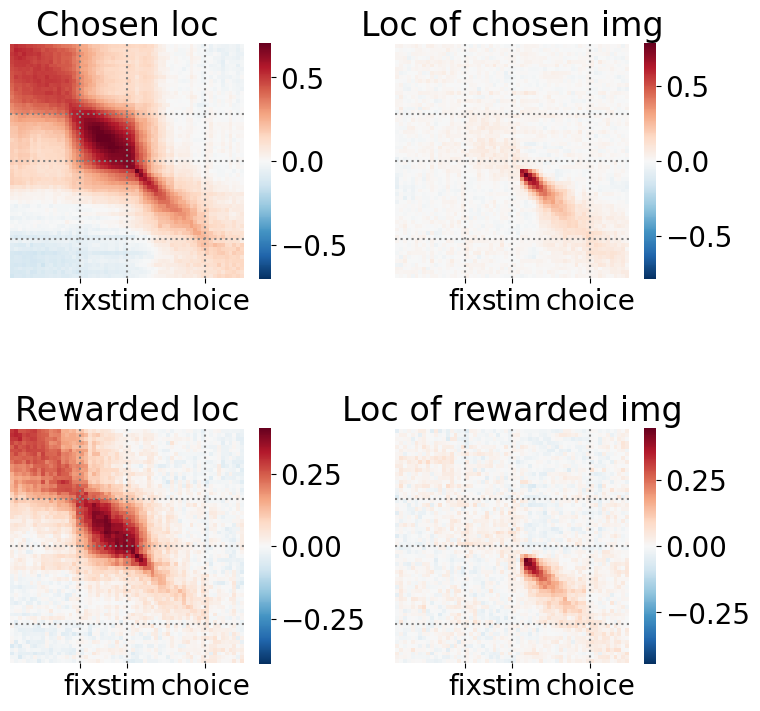

In [17]:
fig, axes = plt.subplots(2,2, figsize=(8, 8))

sims_what = []

sims_what.append(plot_time_varying_correlation(all_sess_betas[...,100]-all_sess_betas[...,101], 
                              all_sess_betas[...,100]+all_sess_betas[...,101], 
                              axes[0,0], title='Chosen loc', vlim=None))
sims_what.append(plot_time_varying_correlation(all_sess_betas[...,130]-all_sess_betas[...,131], 
                              all_sess_betas[...,130]+all_sess_betas[...,131], 
                              axes[0,1], title='Loc of chosen img', vlim=None))

sims_what.append(plot_time_varying_correlation(all_sess_betas[...,104]-all_sess_betas[...,105], 
                              all_sess_betas[...,104]+all_sess_betas[...,105], 
                              axes[1,0], title='Rewarded loc', vlim=None))
sims_what.append(plot_time_varying_correlation(all_sess_betas[...,156]-all_sess_betas[...,157], 
                              all_sess_betas[...,156]+all_sess_betas[...,157], 
                              axes[1,1], title='Loc of rewarded img', vlim=None))

fig.tight_layout()

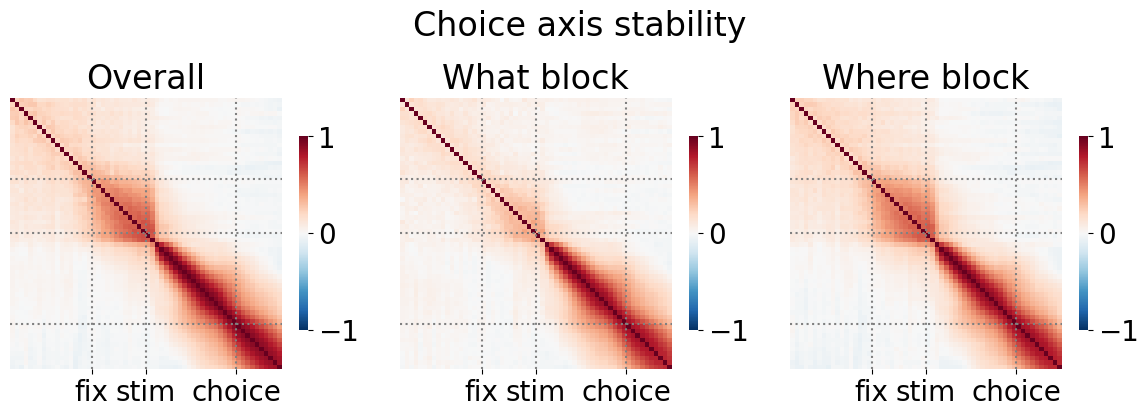

In [18]:
fig, axes = plt.subplots(1,3, figsize=(12, 4))

plot_time_varying_correlation(all_sess_betas[...,72], 
                              all_sess_betas[...,72], 
                              axes[0], title='Overall', vlim=None);

plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,72]+all_sess_betas[...,73], 
                              axes[1], title='What block', vlim=None);

plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,72]-all_sess_betas[...,73], 
                              axes[2], title='Where block', vlim=None);

fig.suptitle('Choice axis stability')
fig.tight_layout()



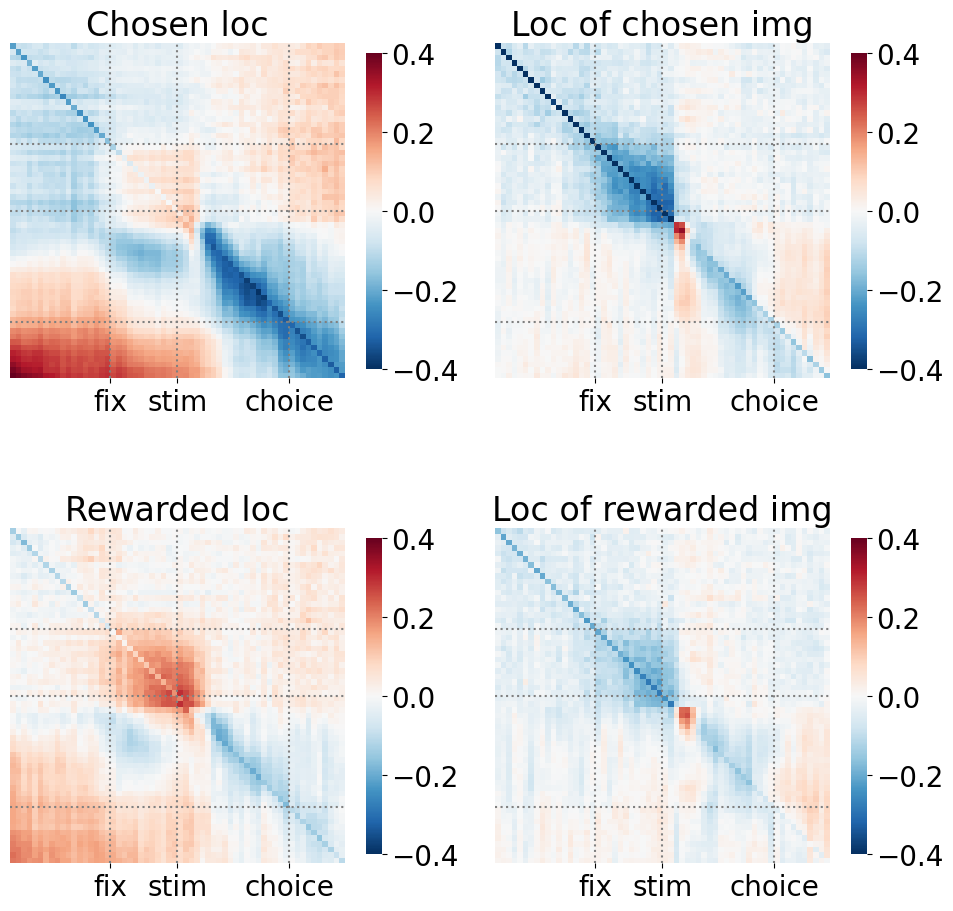

In [19]:
fig, axes = plt.subplots(2,2,figsize=(10,10))

sims_overall = []

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,100], 
                              axes[0,0], title='Chosen loc'))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,130], 
                              axes[0,1], title='Loc of chosen img'))

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,104], 
                              axes[1,0], title='Rewarded loc'))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,156], 
                              axes[1,1], title='Loc of rewarded img'))

fig.tight_layout()


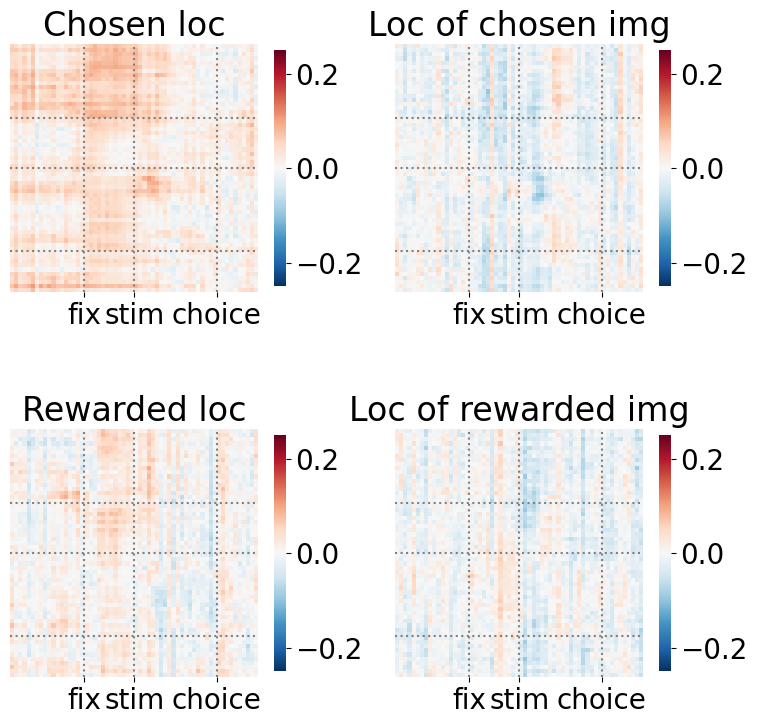

In [20]:
fig, axes = plt.subplots(2,2, figsize=(8,8))

sims_overall = []

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,100], 
                              axes[0,0], title='Chosen loc', vlim=0.25))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,130], 
                              axes[0,1], title='Loc of chosen img', vlim=0.25))

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,104], 
                              axes[1,0], title='Rewarded loc', vlim=0.25))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,156], 
                              axes[1,1], title='Loc of rewarded img', vlim=0.25))

fig.tight_layout()


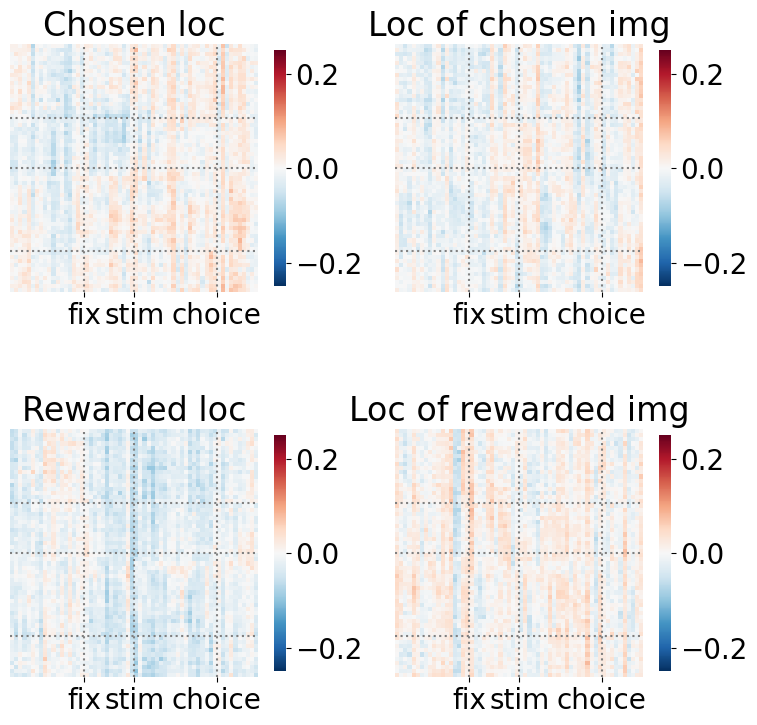

In [21]:
fig, axes = plt.subplots(2,2, figsize=(8,8))

sims_overall = []

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,101], 
                              axes[0,0], title='Chosen loc', vlim=0.25))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,131], 
                              axes[0,1], title='Loc of chosen img', vlim=0.25))

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,105], 
                              axes[1,0], title='Rewarded loc', vlim=0.25))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,1], all_sess_betas[...,157], 
                              axes[1,1], title='Loc of rewarded img', vlim=0.25))

fig.tight_layout()


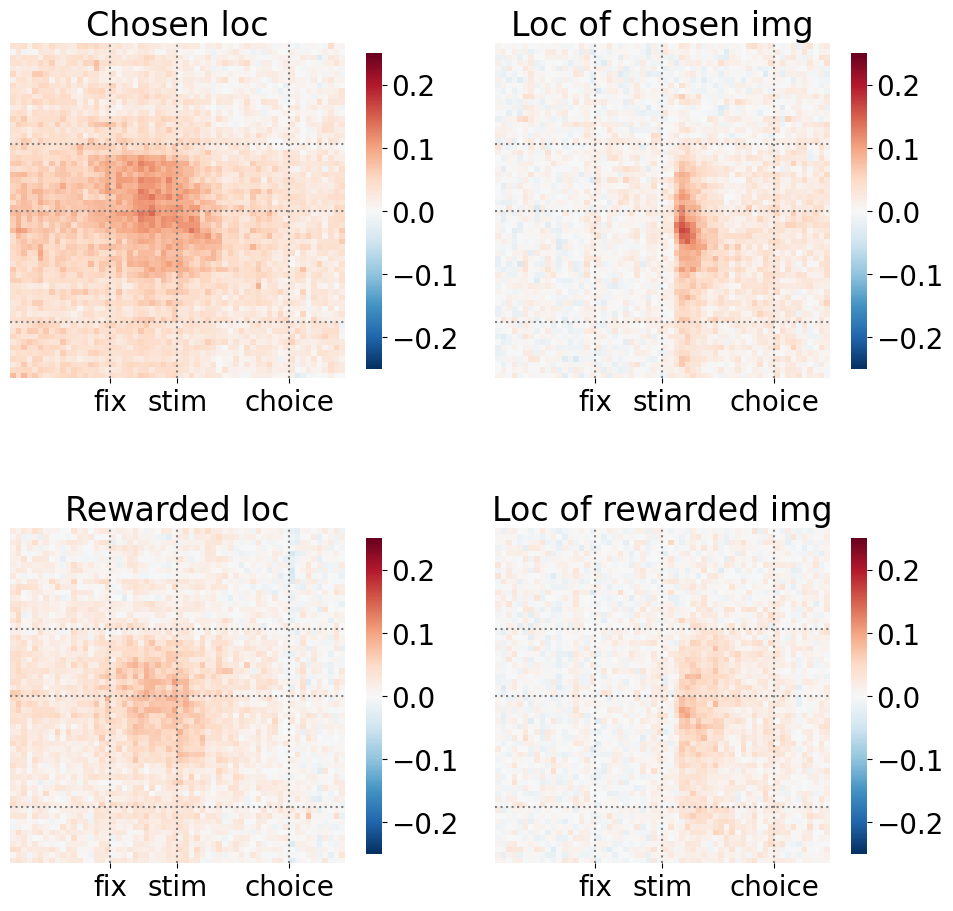

In [22]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

sims_overall = []

sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,16], 
                              axes[0,0], title='Chosen loc', vlim=0.25, metric='corr'))
sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,25], 
                              axes[0,1], title='Loc of chosen img', vlim=0.25, metric='corr'))

sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,20], 
                              axes[1,0], title='Rewarded loc', vlim=0.25, metric='corr'))
sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,30], 
                              axes[1,1], title='Loc of rewarded img', vlim=0.25, metric='corr'))

fig.tight_layout()


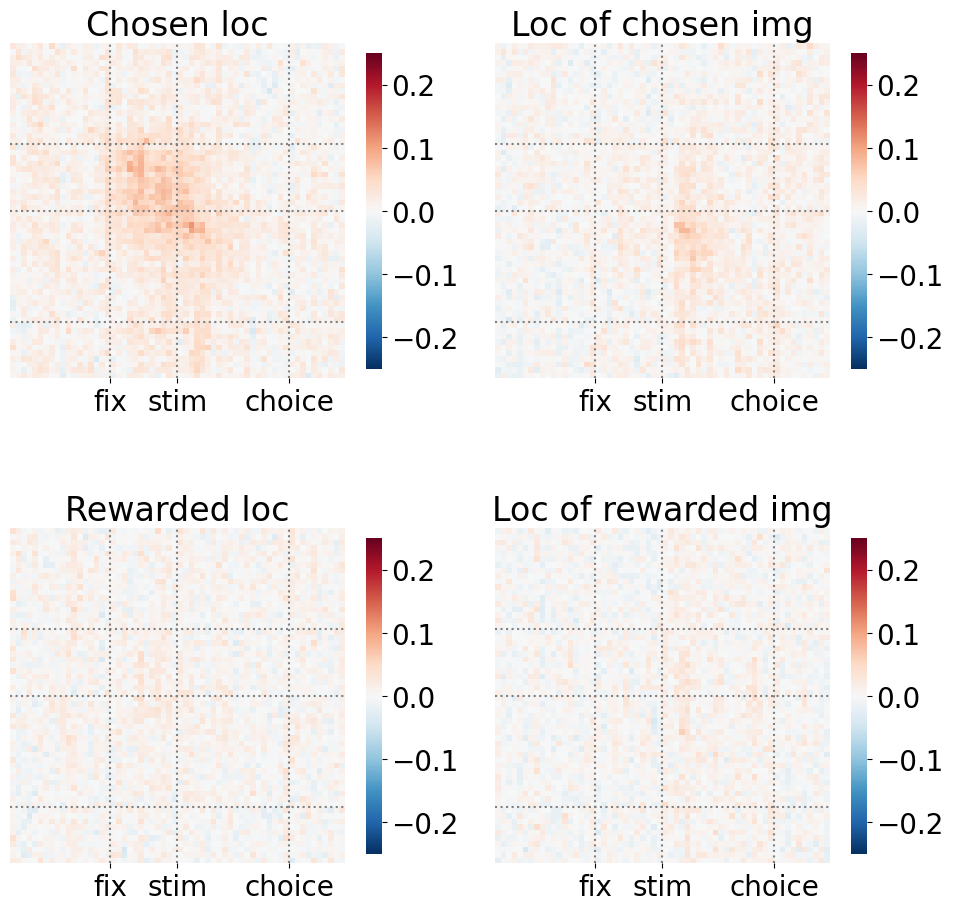

In [23]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

sims_overall = []

sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,17], 
                              axes[0,0], title='Chosen loc', vlim=0.25, metric='corr'))
sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,26], 
                              axes[0,1], title='Loc of chosen img', vlim=0.25, metric='corr'))

sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,21], 
                              axes[1,0], title='Rewarded loc', vlim=0.25, metric='corr'))
sims_overall.append(plot_time_varying_correlation(all_sess_exp_var[...,1], all_sess_exp_var[...,31], 
                              axes[1,1], title='Loc of rewarded img', vlim=0.25, metric='corr'))

fig.tight_layout()


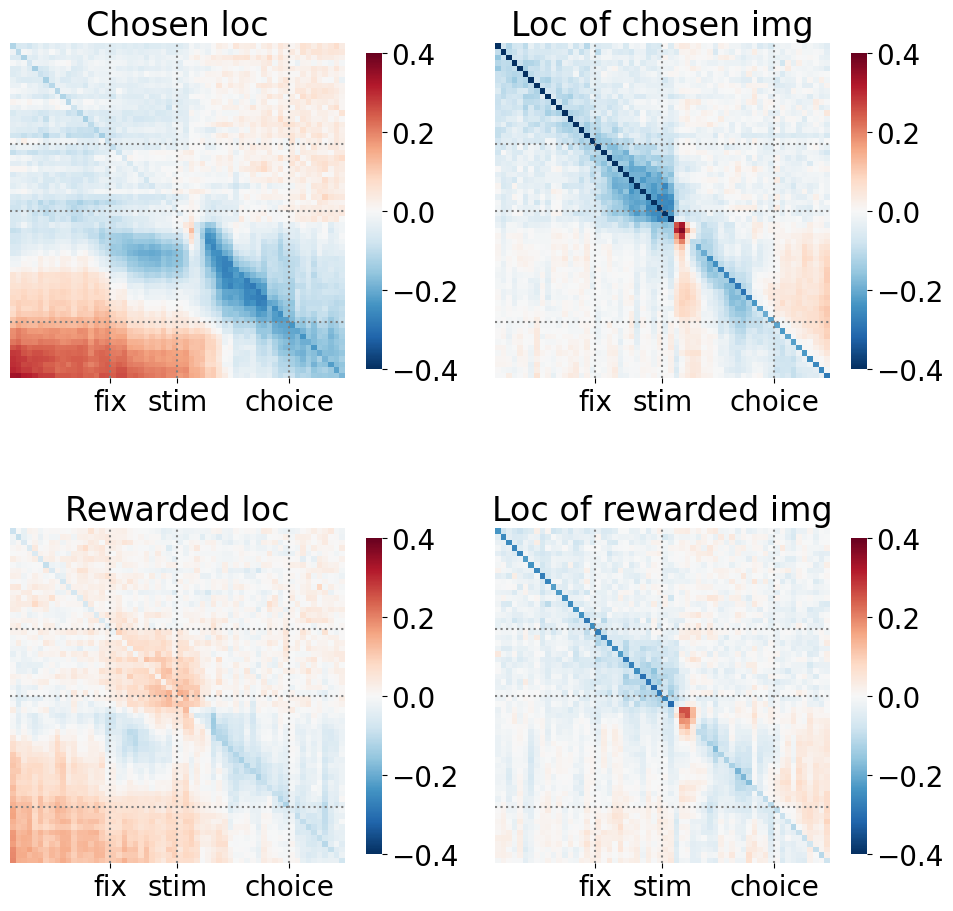

In [24]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

sims_what = []

sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,100]+all_sess_betas[...,101], 
                              axes[0,0], title='Chosen loc'))
sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,130]+all_sess_betas[...,131], 
                              axes[0,1], title='Loc of chosen img'))

sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,104]+all_sess_betas[...,105], 
                              axes[1,0], title='Rewarded loc'))
sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,156]+all_sess_betas[...,157], 
                              axes[1,1], title='Loc of rewarded img'))

fig.tight_layout()

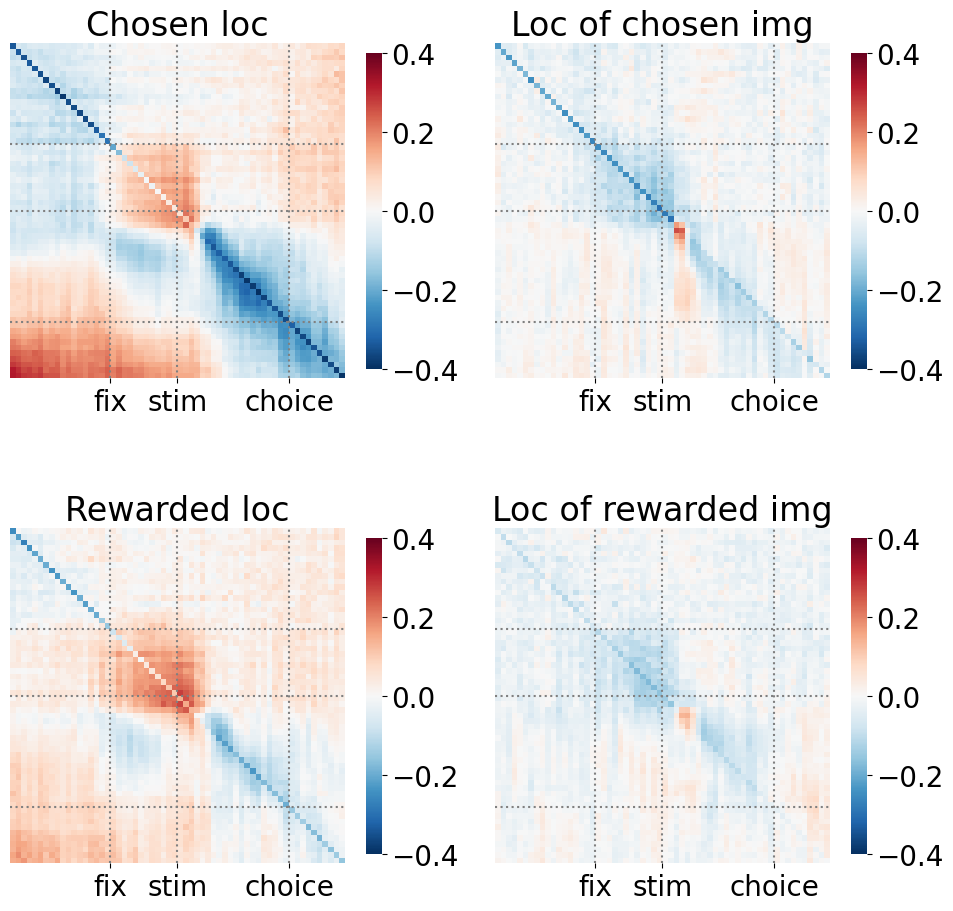

In [25]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))


sims_where = []

sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,100]-all_sess_betas[...,101], 
                              axes[0,0], title='Chosen loc'))
sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,130]-all_sess_betas[...,131], 
                              axes[0,1], title='Loc of chosen img'))

sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,104]-all_sess_betas[...,105], 
                              axes[1,0], title='Rewarded loc'))
sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,156]-all_sess_betas[...,157], 
                              axes[1,1], title='Loc of rewarded img'))

fig.tight_layout()

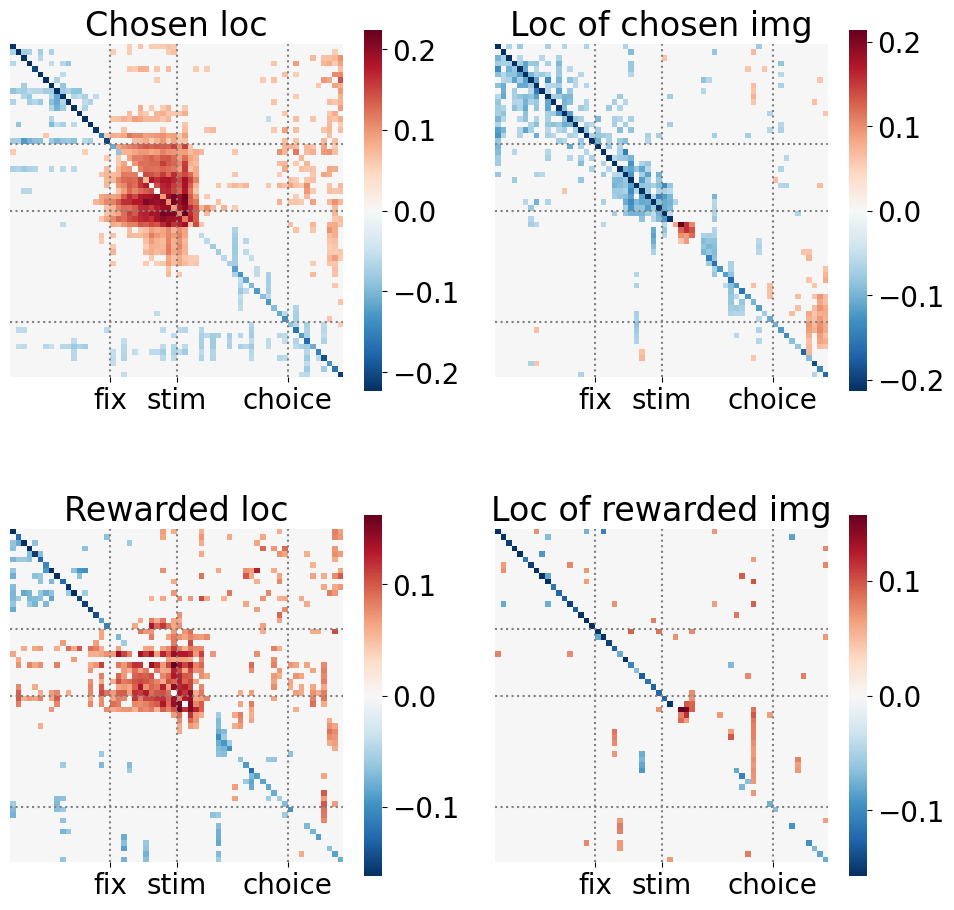

In [26]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

ylabel_names = [['Chosen loc', 'Loc of chosen img'],
                ['Rewarded loc', 'Loc of rewarded img']]



n_neurons = all_sess_betas.shape[1]

for i in range(2):
    for j in range(2):
        ax = axes[i,j]
        if j==1:
            sims_diff = sims_what[i*2+j]-sims_where[i*2+j]
            sims_diff_z = (np.arctanh(sims_what[i*2+j])-np.arctanh(sims_where[i*2+j]))/np.sqrt(2/(n_neurons-3))
            sims_diff_p = 1-norm.cdf(np.abs(sims_diff_z))
        else:
            sims_diff = sims_where[i*2+j]-sims_what[i*2+j]
            sims_diff_z = (np.arctanh(sims_where[i*2+j])-np.arctanh(sims_what[i*2+j]))/np.sqrt(2/(n_neurons-3))
            sims_diff_p = 1-norm.cdf(np.abs(sims_diff_z))
            
        _,adj_p,_,_ = multipletests(sims_diff_p.reshape(60**2), method='fdr_by')
        adj_p = adj_p.reshape((60,60))
        
        vlim=np.max(sims_diff)
        
        sns.heatmap(sims_diff*(adj_p<0.05), 
                    cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
                    ax=ax, square=True, cbar_kws={'shrink': 0.8})
        ax.axvline(50, ls=':', c='grey')
        ax.axhline(50, ls=':', c='grey')
        ax.axvline(30, ls=':', c='grey')
        ax.axhline(30, ls=':', c='grey')
        ax.axvline(18, ls=':', c='grey')
        ax.axhline(18, ls=':', c='grey')
        ax.set_title(ylabel_names[i][j])
        ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=0)
        ax.set_yticks([], [])

fig.tight_layout()

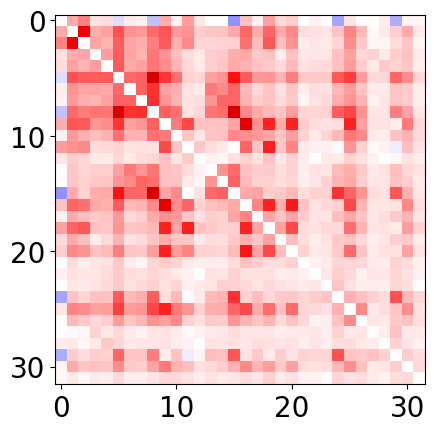

In [18]:
plt.imshow(stats.spearmanr(all_sess_exp_var.mean(0)).statistic-np.eye(32), vmin=-1, vmax=1, cmap='seismic')

## State space representation of choice and history

In [145]:
curr_contrast = all_contrasts[16,:][None,None]

curr_sess_betas = all_sess_regression_info['betas'][2]

u1, s1, vh1 = np.linalg.svd(np.sum(curr_sess_betas[...,48:71]*curr_contrast, -1), full_matrices=False)
u2, s2, vh2 = np.linalg.svd(np.sum(curr_sess_betas[...,76:99]*curr_contrast, -1), full_matrices=False)
u3, s3, vh3 = np.linalg.svd(np.sum(curr_sess_betas[...,106:129]*curr_contrast, -1), full_matrices=False)



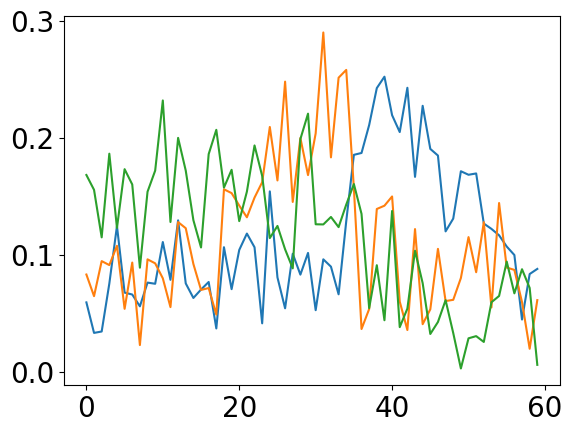

In [146]:
plt.plot(u1[:,0]*np.sign((u1[:,0]).sum()))
plt.plot(u2[:,0]*np.sign((u2[:,0]).sum()))
plt.plot(u3[:,0]*np.sign((u3[:,0]).sum()))

In [62]:
def plot_choice_history_state_space(all_sess_neural_data, all_sess_betas, all_sess_task_info,
                                    ch_axis_func, hist_axis_func, 
                                    curr_ch_func, prev_ch_func, 
                                    prev_rwd_func, block_type_func, 
                                    block_type_to_plot, axes, sep_by_block=False):
    
    '''
    1. pca var explained plot
    2. coeff correlation plot
    3. state space plot
    '''
    
    num_sess = len(all_sess_betas)
    
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    linetyles = ['--', '-']
    
    all_sess_proj_ch = np.zeros((num_sess, 2, 2, 2, 60)) 
    all_sess_proj_hist = np.zeros((num_sess, 2, 2, 2, 60)) 
    
    all_sess_corrs = []
    # num_curr_ch (2) X num_prev_ch (2) X num_rwd (2) X timesteps   
    
    all_proj_ch = []
    all_proj_hist = []
    
    for idx_sess in tqdm.tqdm(range(num_sess)):
        
        # center the neural data to get rid of effect of mean firing rates in projections
        centered_neural_data = \
            (all_sess_neural_data[idx_sess]-all_sess_neural_data[idx_sess].mean(0)).transpose((0,2,1))
        
        if not sep_by_block:
            # svd on curr choice and history axes
            u1, s1, vh1 = np.linalg.svd(ch_axis_func(all_sess_betas[idx_sess]), full_matrices=False)
            u2, s2, vh2 = np.linalg.svd(hist_axis_func(all_sess_betas[idx_sess]), full_matrices=False)

    #         print(s1[0]**2/(s1**2).sum())
    #         print(s2[0]**2/(s2**2).sum())
    #         axis_corr = (stats.pearsonr(vh1[0], vh2[0]))

            vh1 *= np.sign((u1[:,0]).sum())
            vh2 *= np.sign((u2[:,0]).sum())

            axis1 = vh1[0]
            axis2 = vh2[0]-(vh1[0]*vh2[0]).sum()*vh1[0]
            axis2 /= np.sqrt((axis2**2).sum())

            all_sess_corrs.append((vh1[0]*vh2[0]).sum())
            
            # load trial information (current trial choice, prev trial choice, prev trial reward, block type)
            
            curr_sess_curr_ch = curr_ch_func(all_sess_task_info[idx_sess])
            curr_sess_prev_ch = prev_ch_func(all_sess_task_info[idx_sess])
            curr_sess_prev_rwd = prev_rwd_func(all_sess_task_info[idx_sess])
            curr_sess_block_type = block_type_func(all_sess_task_info[idx_sess]).astype(int)
            
            # select only trials with the current block
            curr_sess_curr_ch = curr_sess_curr_ch[curr_sess_block_type==block_type_to_plot].astype(int)
            curr_sess_prev_ch = curr_sess_prev_ch[curr_sess_block_type==block_type_to_plot].astype(int)
            curr_sess_prev_rwd = curr_sess_prev_rwd[curr_sess_block_type==block_type_to_plot].astype(int)

            curr_sess_neural_data = centered_neural_data[1:][curr_sess_block_type==block_type_to_plot]
            
            # project onto svd axes (note that they are not necessarily orthogonal)
            proj_ch = (curr_sess_neural_data*axis1).sum(-1) # num_trials-1 X num_timestep
            proj_hist = (curr_sess_neural_data*axis2).sum(-1) # num_trials-1 X num_timestep
            

                
        else:
            
            curr_sess_curr_ch = []
            curr_sess_prev_ch = []
            curr_sess_prev_rwd = []
            
            proj_ch = []
            proj_hist = []

            blocks_to_plot = np.arange(12) if block_type_to_plot==1 else np.arange(12,24)
            
            for idx_block in list(blocks_to_plot):
                
                # svd on the block-specific stim axes
                curr_contrast = all_contrasts[idx_block,:][None,None]
                u1, s1, vh1 = np.linalg.svd(ch_axis_func(all_sess_betas[idx_sess], curr_contrast), 
                                            full_matrices=False)
                u2, s2, vh2 = np.linalg.svd(hist_axis_func(all_sess_betas[idx_sess], curr_contrast), 
                                            full_matrices=False)
                
                vh1 *= np.sign((u1[:,0]).sum())
                vh2 *= np.sign((u2[:,0]).sum())

                axis1 = vh1[0]
                axis2 = vh2[0]-(vh1[0]*vh2[0]).sum()*vh1[0]
                axis2 /= np.sqrt((axis2**2).sum())
                
                all_sess_corrs.append((vh1[0]*vh2[0]).sum())
                
                # load trial info
                curr_block_curr_ch = curr_ch_func(all_sess_task_info[idx_sess])
                curr_block_prev_ch = prev_ch_func(all_sess_task_info[idx_sess])
                curr_block_prev_rwd = prev_rwd_func(all_sess_task_info[idx_sess])
                curr_block_id = block_type_func(all_sess_task_info[idx_sess]).astype(int)
                
                # select only trials with the current block
                curr_sess_curr_ch.append(curr_block_curr_ch[curr_block_id==idx_block].astype(int))
                curr_sess_prev_ch.append(curr_block_prev_ch[curr_block_id==idx_block].astype(int))
                curr_sess_prev_rwd.append(curr_block_prev_rwd[curr_block_id==idx_block].astype(int))

                curr_block_neural_data = centered_neural_data[1:][curr_block_id==idx_block]
                 
                proj_ch.append((curr_block_neural_data*axis1).sum(-1)) # num_trials-1 X num_timestep
                proj_hist.append((curr_block_neural_data*axis2).sum(-1)) # num_trials-1 X num_timestep

                
            curr_sess_curr_ch = np.concatenate(curr_sess_curr_ch)
            curr_sess_prev_ch = np.concatenate(curr_sess_prev_ch)
            curr_sess_prev_rwd = np.concatenate(curr_sess_prev_rwd)
            
            proj_ch = np.concatenate(proj_ch)
            proj_hist = np.concatenate(proj_hist)

        all_proj_ch.append(proj_ch)
        all_proj_hist.append(proj_hist)

        for (idx_curr_ch, idx_prev_ch, idx_prev_rwd) in itertools.product(range(2),range(2),range(2)):
            all_sess_proj_ch[idx_sess, idx_curr_ch, idx_prev_ch, idx_prev_rwd, :] = \
                            proj_ch[(curr_sess_curr_ch==idx_curr_ch) & \
                                    (curr_sess_prev_ch==idx_prev_ch) & \
                                    (curr_sess_prev_rwd==idx_prev_rwd)].mean(0)
            all_sess_proj_hist[idx_sess, idx_curr_ch, idx_prev_ch, idx_prev_rwd, :] = \
                            proj_hist[(curr_sess_curr_ch==idx_curr_ch) & \
                                      (curr_sess_prev_ch==idx_prev_ch) & \
                                      (curr_sess_prev_rwd==idx_prev_rwd)].mean(0)
                
        
#     print(all_sess_corrs)
    
    all_proj_ch = np.concatenate(all_proj_ch, 0)
    all_proj_hist = np.concatenate(all_proj_hist, 0)

    proj_corr = np.corrcoef(all_proj_ch.T, all_proj_hist.T)[:num_timesteps,num_timesteps:]
    vlims = np.max(np.abs(proj_corr))
    
    sns.heatmap(proj_corr, vmin=-vlims, vmax=vlims, cmap='RdBu_r', 
                square=True, cbar_kws={'shrink': 0.6}, ax=axes[0])
    axes[0].axvline(50, ls=':', c='grey')
    axes[0].axhline(50, ls=':', c='grey')
    axes[0].axvline(30, ls=':', c='grey')
    axes[0].axhline(30, ls=':', c='grey')
    axes[0].axvline(18, ls=':', c='grey')
    axes[0].axhline(18, ls=':', c='grey')
    axes[0].set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=30)
    axes[0].set_yticks([], [])
    
    w_size = 10

    for (idx_curr_ch, idx_prev_ch, idx_prev_rwd) in \
            itertools.product(range(2),range(2),range(2)):
        curr_cond_proj_ch_avg = all_sess_proj_ch.mean(0)\
                                    [idx_curr_ch, idx_prev_ch, idx_prev_rwd]
        curr_cond_proj_ch_avg = np.convolve(curr_cond_proj_ch_avg, np.ones(w_size)/w_size, mode='valid')

        curr_cond_proj_hist_avg = all_sess_proj_hist.mean(0)\
                                    [idx_curr_ch, idx_prev_ch, idx_prev_rwd]
        curr_cond_proj_hist_avg = np.convolve(curr_cond_proj_hist_avg, np.ones(w_size)/w_size, mode='valid')
        
        axes[1].plot(curr_cond_proj_ch_avg, curr_cond_proj_hist_avg,
                 c=colors[idx_curr_ch*2+idx_prev_ch], ls=linetyles[idx_prev_rwd],
                 label=f'{idx_curr_ch}, {idx_prev_ch}, {idx_prev_rwd}')
        
        ax_lims = max(max(np.abs(axes[1].get_xlim())), 
                      max(np.abs(axes[1].get_ylim())))
        
        axes[1].arrow(curr_cond_proj_ch_avg[-1], curr_cond_proj_hist_avg[-1],
                      curr_cond_proj_ch_avg[-1]-curr_cond_proj_ch_avg[-2], 
                      curr_cond_proj_hist_avg[-1]-curr_cond_proj_hist_avg[-2],
                      edgecolor=colors[idx_curr_ch*2+idx_prev_ch], facecolor='white',
                      ls=linetyles[idx_prev_rwd], width=ax_lims/100)
        

        for event_idx, event_time in enumerate([0, 18-w_size, 30-w_size, 50-w_size]):
            axes[1].scatter(curr_cond_proj_ch_avg[event_time], curr_cond_proj_hist_avg[event_time],
                         s=(event_idx+4)*5, c='white', edgecolors='k', zorder=-1)
            
    

100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


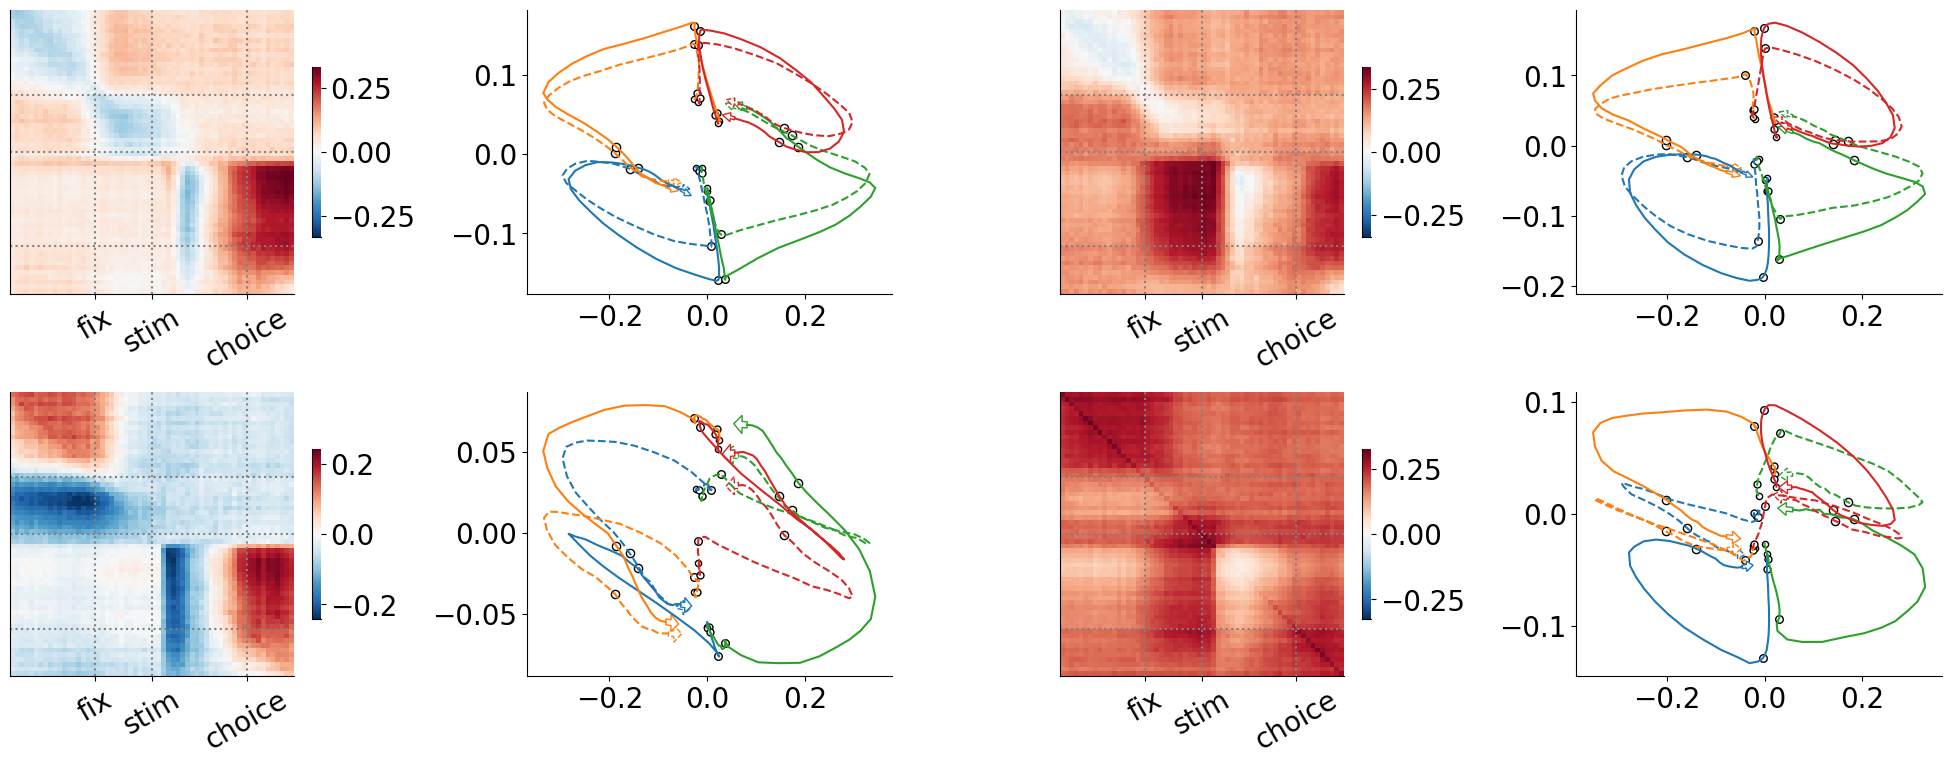

In [63]:
fig, axes = plt.subplots(2,4, figsize=(20,8))

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]+x[...,73], lambda x: x[...,100]+x[...,101], 
    lambda x: x[1:,1], lambda x: x[:-1,1], lambda x: x[:-1,2], lambda x: x[1:,3], 
    1, axes[0,0:2]
)

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]-x[...,73], lambda x: x[...,100]-x[...,101], 
    lambda x: x[1:,1], lambda x: x[:-1,1], lambda x: x[:-1,2], lambda x: x[1:,3], 
    2, axes[0,2:4]
)

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]+x[...,73], lambda x: x[...,104]+x[...,105], 
    lambda x: x[1:,1], lambda x: x[:-1,1], lambda x: x[:-1,2], lambda x: x[1:,3], 
    1, axes[1,0:2]
)

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]-x[...,73], lambda x: x[...,104]-x[...,105], 
    lambda x: x[1:,1], lambda x: x[:-1,1], lambda x: x[:-1,2], lambda x: x[1:,3], 
    2, axes[1,2:4]
)


sns.despine()
# axes[1,1].legend(bbox_to_anchor=(1.1,1.2))

fig.tight_layout()

100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


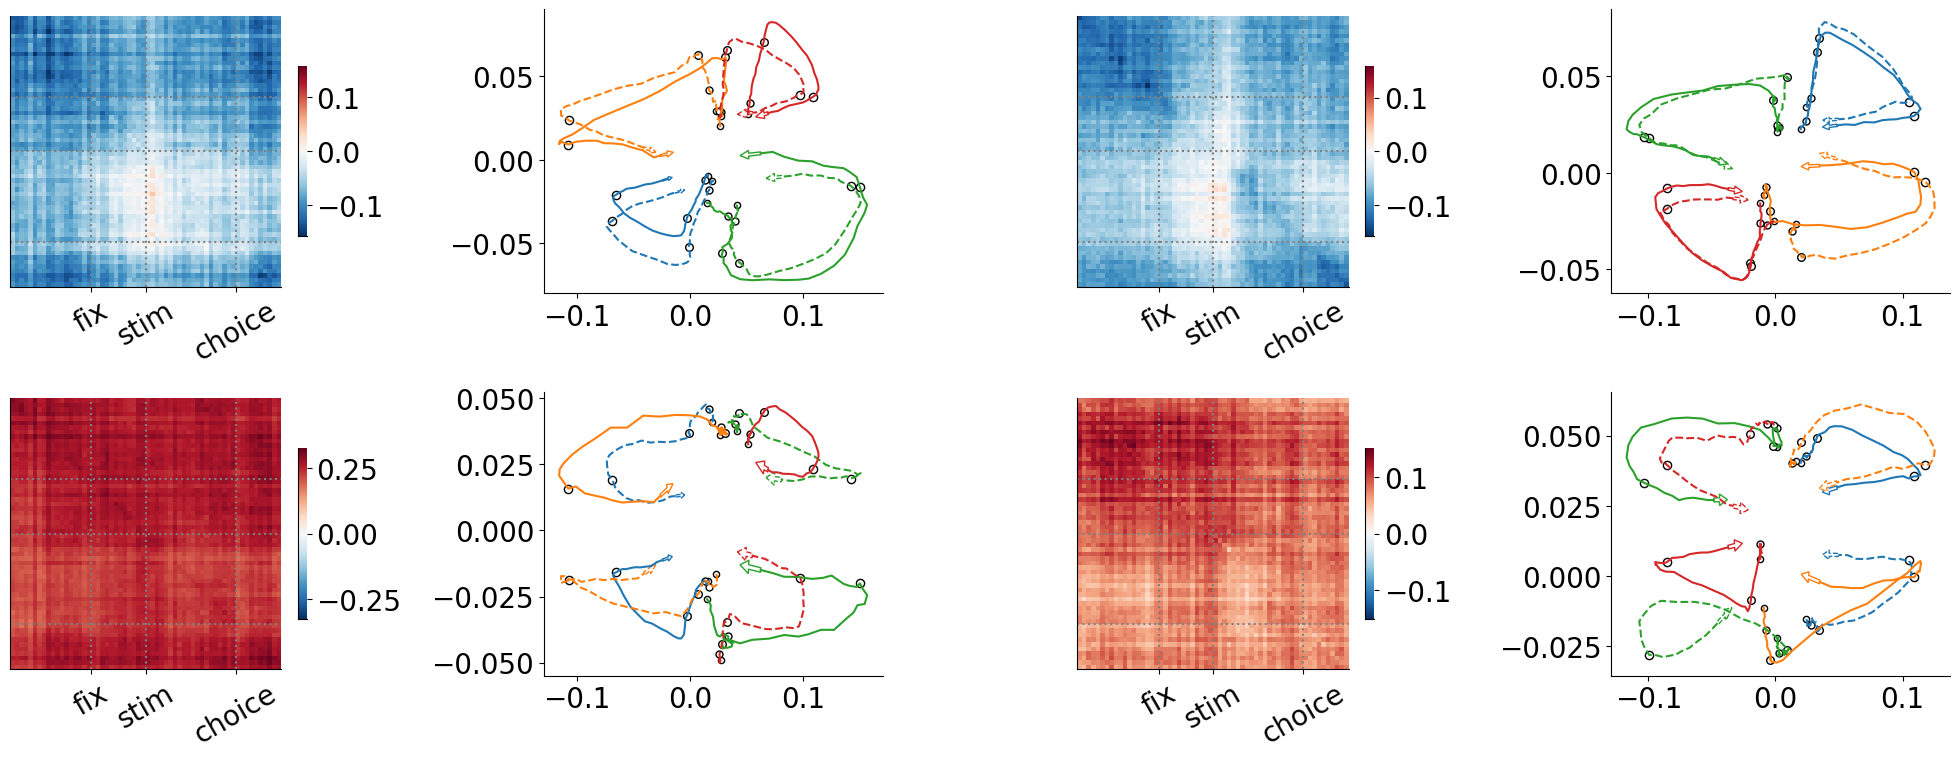

In [55]:
fig, axes = plt.subplots(2,4, figsize=(20,8))

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x, y: np.sum(x[...,48:71]*y, -1), 
    lambda x, y: np.sum(x[...,76:99]*y, -1),
    lambda x: x[1:,0], lambda x: x[:-1,0], lambda x: x[:-1,2], lambda x: x[1:,4], 
    1, axes[0,0:2], True
)

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x, y: np.sum(x[...,48:71]*y, -1), 
    lambda x, y: np.sum(x[...,76:99]*y, -1),
    lambda x: x[1:,0], lambda x: x[:-1,0], lambda x: x[:-1,2], lambda x: x[1:,4], 
    2, axes[0,2:4], True
)

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x, y: np.sum(x[...,48:71]*y, -1), 
    lambda x, y: np.sum(x[...,106:129]*y, -1),
    lambda x: x[1:,0], lambda x: x[:-1,0], lambda x: x[:-1,2], lambda x: x[1:,4], 
    1, axes[1,0:2], True
)

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x, y: np.sum(x[...,48:71]*y, -1), 
    lambda x, y: np.sum(x[...,106:129]*y, -1),
    lambda x: x[1:,0], lambda x: x[:-1,0], lambda x: x[:-1,2], lambda x: x[1:,4], 
    2, axes[1,2:4], True
)


sns.despine()
# axes[1,1].legend(bbox_to_anchor=(1.1,1.2))

fig.tight_layout()

100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


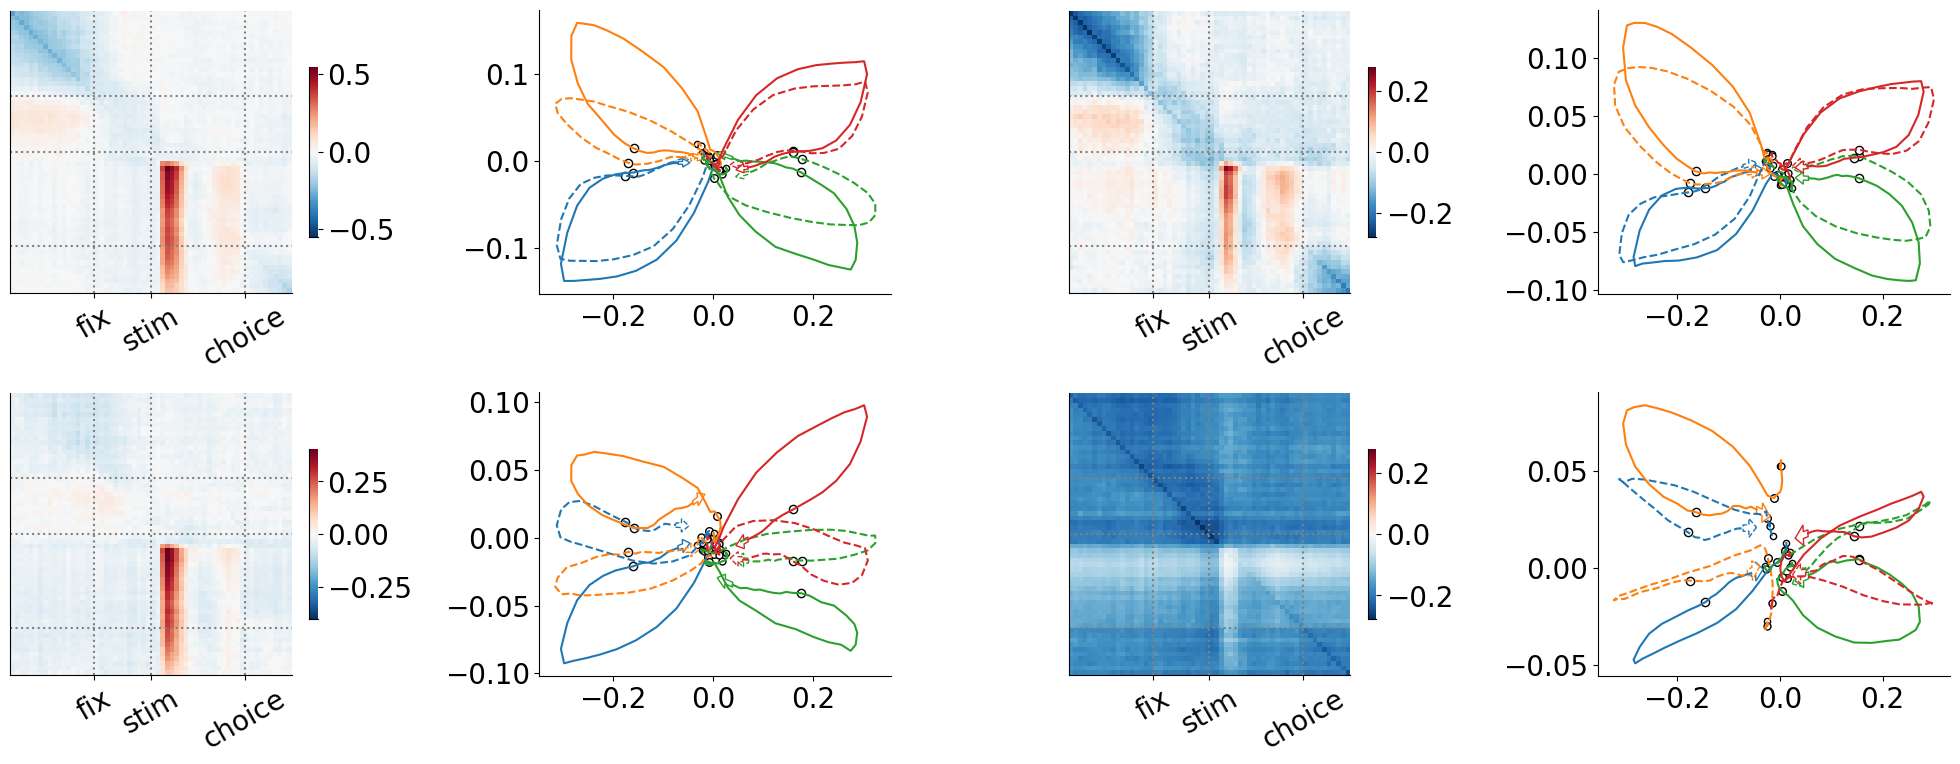

In [43]:
fig, axes = plt.subplots(2,4, figsize=(20,8))

cr_what_func = lambda x: ((2*x[1:,0]-1)*(2*x[1:,1]-1)*(2*x[:-1,0]-1)+1)/2

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]+x[...,73], lambda x: x[...,130]+x[...,131], 
    lambda x: x[1:,1], cr_what_func, lambda x: x[:-1,2], lambda x: x[1:,3], 
    1, axes[0,0:2]
)

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]-x[...,73], lambda x: x[...,130]-x[...,131], 
    lambda x: x[1:,1], cr_what_func, lambda x: x[:-1,2], lambda x: x[1:,3], 
    2, axes[0,2:4]
)

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]+x[...,73], lambda x: x[...,156]+x[...,157], 
    lambda x: x[1:,1], cr_what_func, lambda x: x[:-1,2], lambda x: x[1:,3], 
    1, axes[1,0:2]
)

plot_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]-x[...,73], lambda x: x[...,156]-x[...,157], 
    lambda x: x[1:,1], cr_what_func, lambda x: x[:-1,2], lambda x: x[1:,3], 
    2, axes[1,2:4]
)


sns.despine()
# axes[1,1].legend(bbox_to_anchor=(1.1,1.2))
fig.tight_layout()


## Dynamic arbitration signal

100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


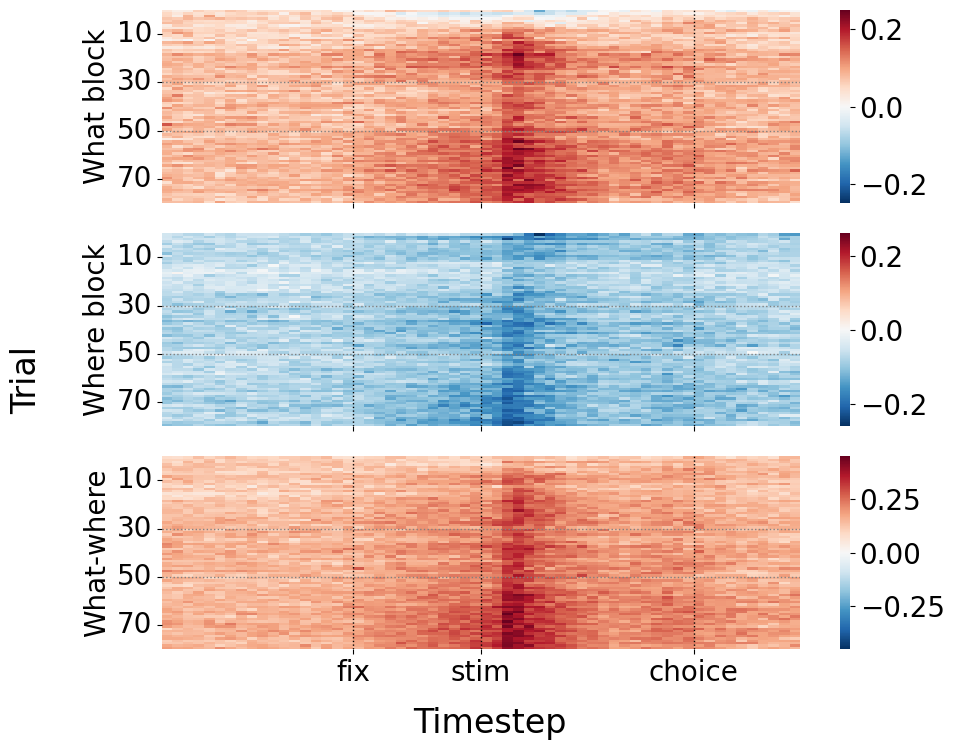

In [21]:
fig, axes = plt.subplots(3,1,figsize=(10,8),sharex=True)

betas_func = lambda x: x[...,1]

all_sess_avg_alignment = trialwise_subspace_alignment(all_sess_neural_data, 
                                                      all_sess_task_info, 
                                                      all_sess_regression_info['betas'],
                                                      betas_func,
                                                      axes)

fig.supylabel('Trial')
fig.supxlabel('Timestep', y=0.05)
fig.tight_layout()


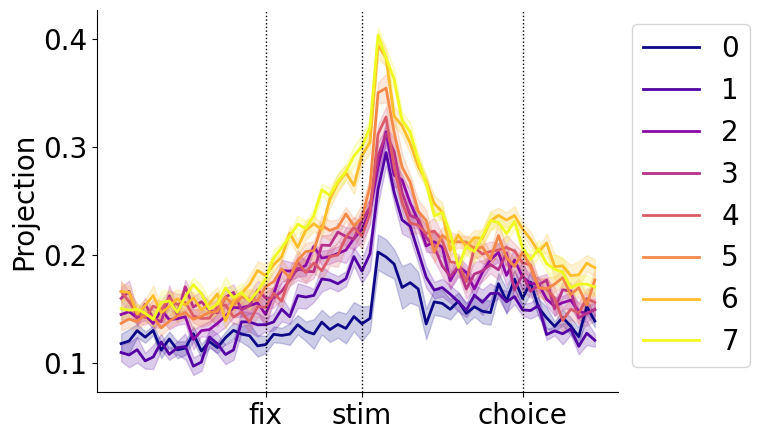

In [22]:
import matplotlib as mpl

cmap = mpl.colormaps['plasma']

chunks = 8
trials_per_chunk = 80//chunks

colors = cmap(np.linspace(0, 1, chunks))

fig, ax = plt.subplots(figsize=(8,4.8))


for i in range(chunks):    
    plot_mean_se(ax, xxx, (all_sess_avg_alignment[0]-all_sess_avg_alignment[1])[i*trials_per_chunk:(i+1)*trials_per_chunk],
                 color=colors[i], label=i, axis=0)
    
    
ax.axvline(-600, ls=':', c='k', lw=1)
ax.axvline(0, ls=':', c='k', lw=1)
ax.axvline(1000, ls=':', c='k', lw=1)
ax.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'])
ax.set_ylabel('Projection')

ax.legend(bbox_to_anchor=(1,1))

sns.despine()
fig.tight_layout()

In [263]:
print(all_sess_neural_data[0].shape, all_sess_regression_info['betas'][0].shape)

(1923, 564, 300) (300, 564, 158)


100%|██████████| 8/8 [00:41<00:00,  5.15s/it]


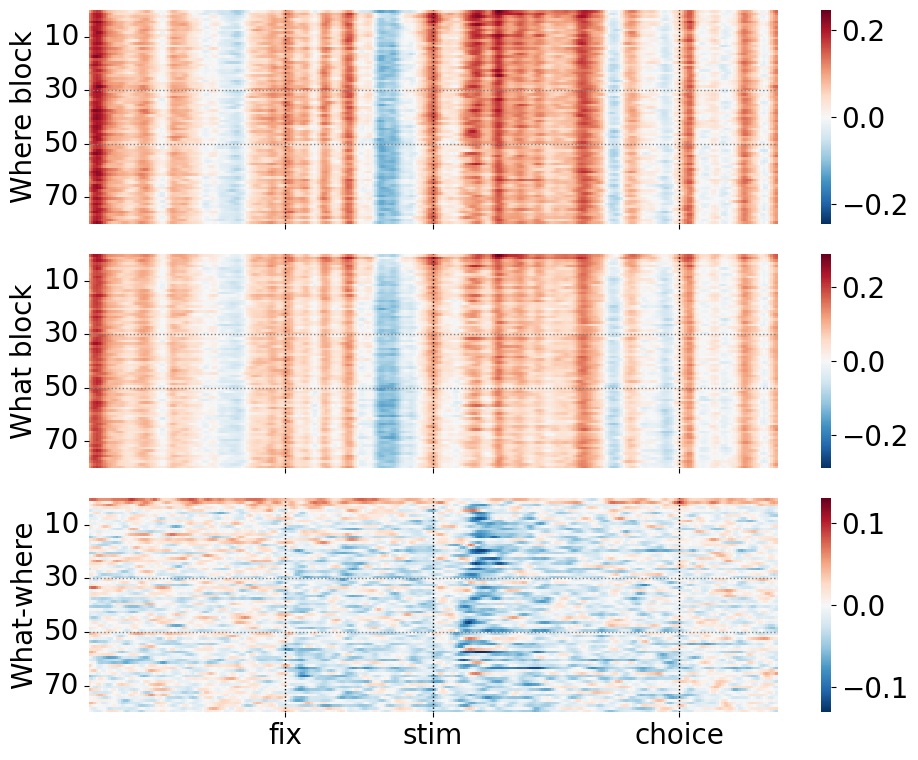

In [265]:
fig, axes = plt.subplots(3,1, figsize=(10, 8),sharex=True)

betas_func = lambda x: x[...,73]

all_sess_avg_alignment = trialwise_subspace_alignment(all_sess_neural_data, 
                                                      all_sess_task_info, 
                                                      all_sess_regression_info['betas'],
                                                      betas_func, axes)

fig.tight_layout()


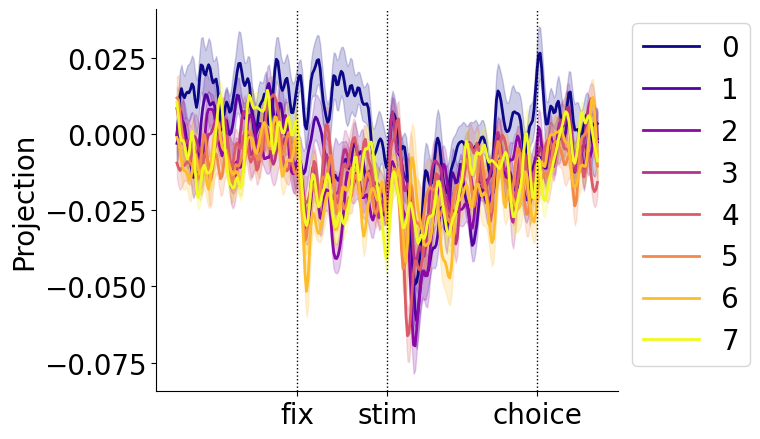

In [269]:
import matplotlib as mpl

cmap = mpl.colormaps['plasma']

chunks = 8
trials_per_chunk = 80//chunks

colors = cmap(np.linspace(0, 1, chunks))

fig, ax = plt.subplots(figsize=(8,4.8))


xxx = np.linspace(-1400, 1400, num=280)
for i in range(chunks):    
    plot_mean_se(ax, xxx, (all_sess_avg_alignment[1]-all_sess_avg_alignment[0])[i*trials_per_chunk:(i+1)*trials_per_chunk],
                 color=colors[i], label=i, axis=0)
    
    
ax.axvline(-600, ls=':', c='k', lw=1)
ax.axvline(0, ls=':', c='k', lw=1)
ax.axvline(1000, ls=':', c='k', lw=1)
ax.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'])
ax.set_ylabel('Projection')

ax.legend(bbox_to_anchor=(1,1))

sns.despine()
fig.tight_layout()

100%|██████████| 8/8 [00:35<00:00,  4.40s/it]


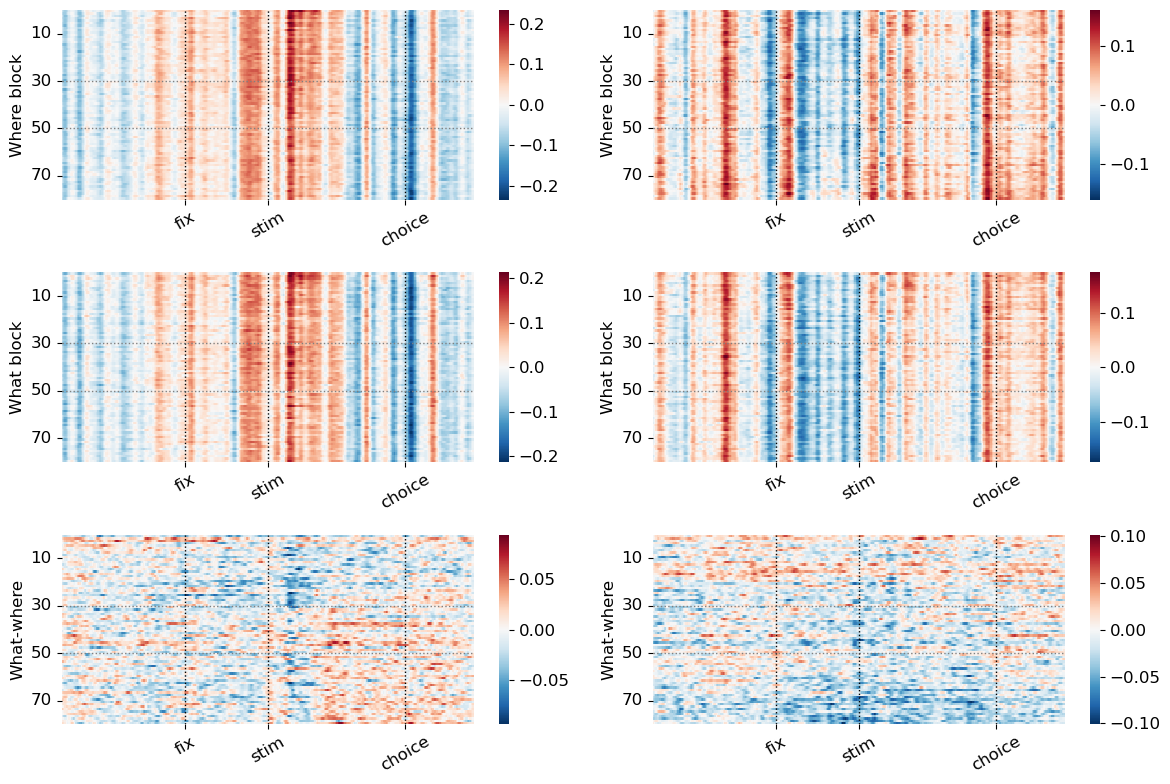

In [48]:
fig, axes = plt.subplots(3,2, figsize=(12, 8))

betas_func = lambda x: x[...,101]

all_sess_avg_alignment = trialwise_subspace_alignment(all_sess_neural_data, 
                                                      all_sess_task_info, 
                                                      all_sess_regression_info['betas'],
                                                      betas_func, axes[:,0])

betas_func = lambda x: x[...,105]

all_sess_avg_alignment = trialwise_subspace_alignment(all_sess_neural_data, 
                                                      all_sess_task_info, 
                                                      all_sess_regression_info['betas'],
                                                      betas_func, axes[:,1])

fig.tight_layout()


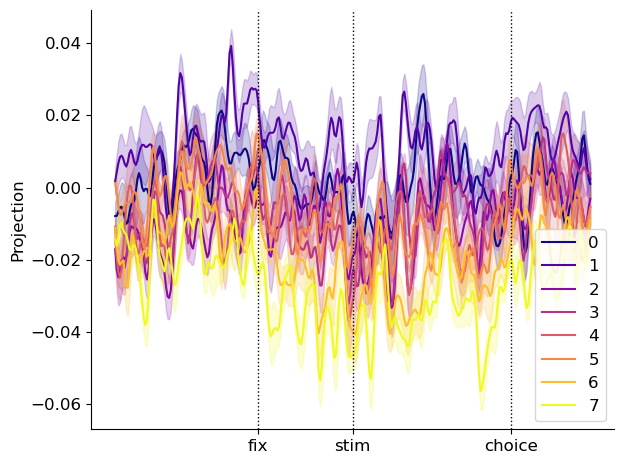

In [49]:
import matplotlib as mpl

cmap = mpl.colormaps['plasma']

chunks = 8
trials_per_chunk = 80//chunks

colors = cmap(np.linspace(0, 1, chunks))

fig, ax = plt.subplots()


xxx = np.linspace(-1400, 1400, num=200)
for i in range(chunks):    
    plot_mean_se(ax, xxx, (all_sess_avg_alignment[1]-all_sess_avg_alignment[0])[i*trials_per_chunk:(i+1)*trials_per_chunk],
                 color=colors[i], label=i, axis=0)
    
    
ax.axvline(-600, ls=':', c='k', lw=1)
ax.axvline(0, ls=':', c='k', lw=1)
ax.axvline(1000, ls=':', c='k', lw=1)
ax.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'])
ax.set_ylabel('Projection')

ax.legend()

sns.despine()
fig.tight_layout()

/scratch/ipykernel_4077/2717403919.py:13: RuntimeWarning: invalid value encountered in multiply
  all_sess_avg_alignment = np.empty((2, num_trials_per_block, num_timesteps))*np.nan
100%|██████████| 8/8 [00:40<00:00,  5.05s/it]
/scratch/ipykernel_4077/2717403919.py:13: RuntimeWarning: invalid value encountered in multiply
  all_sess_avg_alignment = np.empty((2, num_trials_per_block, num_timesteps))*np.nan
100%|██████████| 8/8 [00:35<00:00,  4.48s/it]


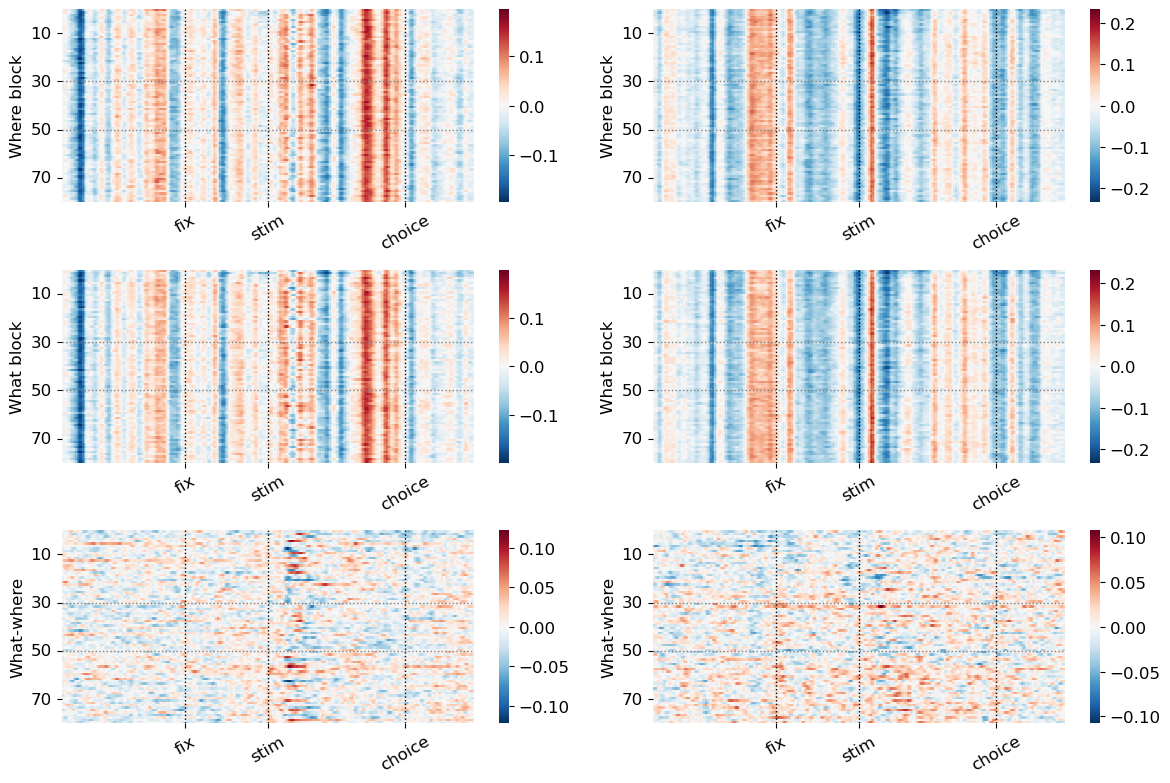

In [50]:
fig, axes = plt.subplots(3,2, figsize=(12, 8))

betas_func = lambda x: x[...,131]

all_sess_avg_alignment = trialwise_subspace_alignment(all_sess_neural_data, 
                                                      all_sess_task_info, 
                                                      all_sess_regression_info['betas'],
                                                      betas_func, axes[:,0])

betas_func = lambda x: x[...,157]

all_sess_avg_alignment = trialwise_subspace_alignment(all_sess_neural_data, 
                                                      all_sess_task_info, 
                                                      all_sess_regression_info['betas'],
                                                      betas_func, axes[:,1])

fig.tight_layout()


/scratch/ipykernel_2888/1248521363.py:13: RuntimeWarning: invalid value encountered in multiply
  all_sess_avg_alignment = np.empty((2, num_trials_per_block, num_timesteps))*np.nan
100%|██████████| 8/8 [00:33<00:00,  4.15s/it]


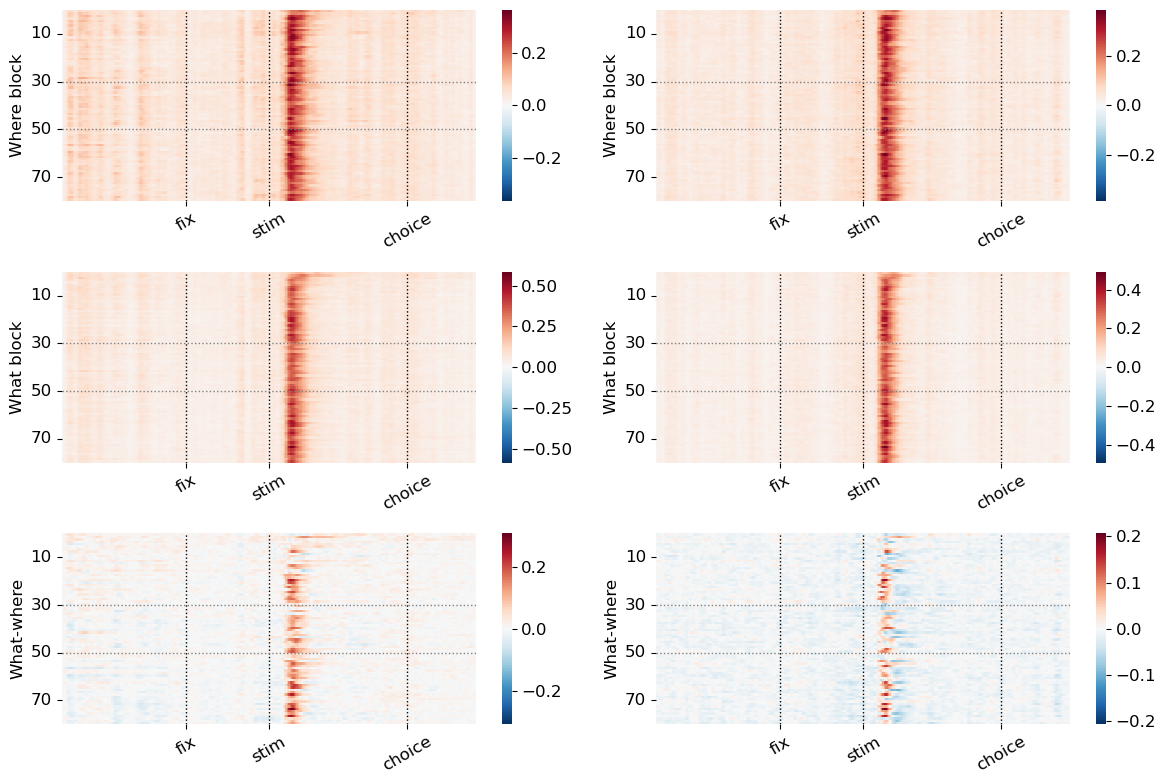

In [24]:
fig, axes = plt.subplots(3,2, figsize=(12, 8))

betas_func = lambda x: x[...,130]+x[...,131]

all_sess_avg_alignment = trialwise_subspace_alignment(all_sess_neural_data, 
                                                      all_sess_task_info, 
                                                      all_sess_regression_info['betas'],
                                                      betas_func, axes[:,0], 
                                                      absolute_proj=True)

betas_func = lambda x: x[...,130]-x[...,131]

all_sess_avg_alignment = trialwise_subspace_alignment(all_sess_neural_data, 
                                                      all_sess_task_info, 
                                                      all_sess_regression_info['betas'],
                                                      betas_func, axes[:,1], 
                                                      absolute_proj=True)

fig.tight_layout()


100%|██████████| 8/8 [00:33<00:00,  4.13s/it]


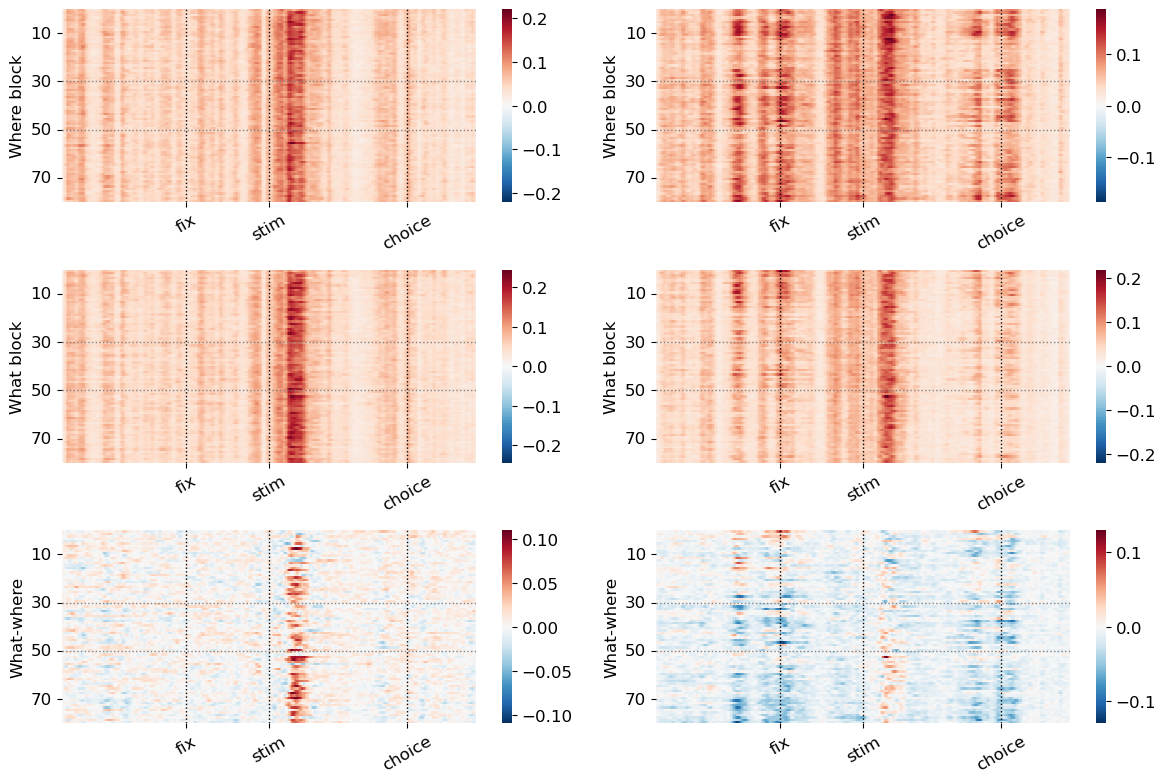

In [25]:
fig, axes = plt.subplots(3,2, figsize=(12, 8))

betas_func = lambda x: x[...,156]+x[...,157]

all_sess_avg_alignment = trialwise_subspace_alignment(all_sess_neural_data, 
                                                      all_sess_task_info, 
                                                      all_sess_regression_info['betas'],
                                                      betas_func, axes[:,0], 
                                                      absolute_proj=True)

betas_func = lambda x: x[...,156]-x[...,157]

all_sess_avg_alignment = trialwise_subspace_alignment(all_sess_neural_data, 
                                                      all_sess_task_info, 
                                                      all_sess_regression_info['betas'],
                                                      betas_func, axes[:,1], 
                                                      absolute_proj=True)

fig.tight_layout()
